In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import scipy
import seaborn as sns
import math
from Bio import SeqIO
import Bio
import sklearn

In [ ]:
!pip install Biopython

     |████████████████████████████████| 2.3 MB 6.9 MB/s 


In [ ]:
import os
from google.colab import files
files.upload()

Saving ProteinFastaResults.tar.gz to ProteinFastaResults.tar.gz


In [ ]:
!tar --gunzip --extract --verbose --file="ProteinFastaResults.tar.gz" 

#### Для загрузки данных в формате fasta будем использовать библиотеку Biopython

In [ ]:
data = []
f = True
columns = []
fasta_sequences = SeqIO.parse(open("895669196588-ProteinFastaResults.fasta"),'fasta')
for fasta in fasta_sequences:
    line = []
    ids = fasta.description.split("|")
    if(f):
        for i in ids:
            line.append(str(i.split(":")[1]))
            columns.append(str(i.split(":")[0]))
        f = False
    else:
        for i in ids:
            line.append(str(i.split(":")[1])) 
    line.append(str(fasta.seq))
    data.append(line)
columns+=["seq"]

In [ ]:
df = pd.DataFrame(data,columns = columns)

In [ ]:
df.head()

,gb,ncbiId,UniProtKB,Organism,Strain Name,Protein Name,Gene Symbol,Segment,Subtype,Host,seq
0,CY065439,AEW10945.1,G8XL06,Influenza A virus (A/England/257/2009(H1N1)),A/England/257/2009,NP Nucleoprotein,NP,5,H1N1,Human,MASQGTKRSYEQMETGGERQDATEIRASVGRMIGGIGRFYIQMCTE...
1,JX309413,AFP35342.1,I7F9I9,Influenza A virus (A/Singapore/SS13/2010(H1N1)),A/Singapore/SS13/2010,NS2 Non-structural protein 2,NS2,8,H1N1,Human,MDSNTMSSFQDILMRMSKMQLGSSSEDLNGMVTRFESLKIYRDSLG...
2,JX309413,AFP35341.1,I7FSX8,Influenza A virus (A/Singapore/SS13/2010(H1N1)),A/Singapore/SS13/2010,NS1 Non-structural protein 1,NS1,8,H1N1,Human,MDSNTMSSFQVDCFLWHIRKRFADNGLGDAPFLDRLRRDQKSLKGR...
3,JX309187,AFP35057.1,I7F8Q1,Influenza A virus (A/Singapore/GP720/2010(H1N1)),A/Singapore/GP720/2010,HA Hemagglutinin,HA,4,H1N1,Human,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...
4,LN867744,CRX62781.1,A0A0H5F5N4,Influenza A virus (A/England/05100660/2010(H1N1)),A/England/05100660/2010,NS2 Non-structural protein 2,NS2,8,H1N1,Human,MDSNTMSSFQDILMRMSKMQLGSSSEDLNGMVTRFESLKIYRDSLG...


# EDA

Поля gb ncbild и UniProtKB являются референсами на данные для этих 3ех баз, в связи с чем данные поля не несут информации по задачи и их можно опустить.

In [ ]:
df = df.drop(["gb","ncbiId","UniProtKB"],axis = 1)

In [ ]:
df.info() #посмотрим данные на явные пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238030 entries, 0 to 238029
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Organism      238030 non-null  object
 1   Strain Name   238030 non-null  object
 2   Protein Name  238030 non-null  object
 3   Gene Symbol   238030 non-null  object
 4   Segment       238030 non-null  object
 5   Subtype       238030 non-null  object
 6   Host          234120 non-null  object
 7   seq           234120 non-null  object
dtypes: object(8)
memory usage: 14.5+ MB


In [ ]:
df.isna().sum() #Поскольку сама последовательность основная информация, а проспусков не так много, просто выкинем эти данные.

Organism           0
Strain Name        0
Protein Name       0
Gene Symbol        0
Segment            0
Subtype            0
Host            3910
seq             3910
dtype: int64

In [ ]:
df = df.dropna() 

Колонка "Strain Name" содержит комплексную информацию страна/время, разобьем ее на 2 колонки

In [ ]:
df["Place"] = df["Strain Name"].apply(lambda x: x.split("/")[1])
df["year"] = df["Strain Name"].apply(lambda x: x.split("/")[-1])
df = df.drop(["Strain Name","Organism"],axis = 1)

In [ ]:
df["seq_len"] = df["seq"].apply(lambda x: len(x)) #аналогично столбцам на сайте базы данных, добавим в данные длину последовательности.

In [ ]:
df.head()

,Protein Name,Gene Symbol,Segment,Subtype,Host,seq,Place,year,seq_len
0,NP Nucleoprotein,NP,5,H1N1,Human,MASQGTKRSYEQMETGGERQDATEIRASVGRMIGGIGRFYIQMCTE...,England,2009,498
1,NS2 Non-structural protein 2,NS2,8,H1N1,Human,MDSNTMSSFQDILMRMSKMQLGSSSEDLNGMVTRFESLKIYRDSLG...,Singapore,2010,121
2,NS1 Non-structural protein 1,NS1,8,H1N1,Human,MDSNTMSSFQVDCFLWHIRKRFADNGLGDAPFLDRLRRDQKSLKGR...,Singapore,2010,219
3,HA Hemagglutinin,HA,4,H1N1,Human,MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHS...,Singapore,2010,566
4,NS2 Non-structural protein 2,NS2,8,H1N1,Human,MDSNTMSSFQDILMRMSKMQLGSSSEDLNGMVTRFESLKIYRDSLG...,England,2010,121


In [ ]:
df.describe(include=[np.object])

<ipython-input-12-554b7518cb2b>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.describe(include=[np.object])


,Protein Name,Gene Symbol,Segment,Subtype,Host,seq,Place,year
count,234120,234120,234120,234120,234120,234120,234120,234120
unique,25,17,8,6,3,49103,1232,182
top,HA Hemagglutinin,HA,3,H1N1,Human,MSLLTEVETYVLSIIPSGPLKAEIAQRLESVFAGKNTDLEALMEWL...,New York,2009
freq,34532,34532,50716,232218,234040,6904,14365,70861


### Общий обзор отдельных столбцов загруженных данных.

Из describe сразу заметно что "Host" содержит только 3 уникальных значения из которых Human составляет абсолютное большинство, учитывая что по запросу в базе нам были необходимы только данные со значением Human, остальные значения скорее всего являются ошибками. 

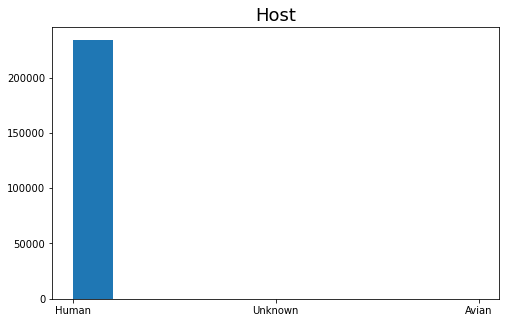

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df["Host"])
plt.title("Host", fontsize=18)
plt.show()

In [ ]:
df["Host"].value_counts()

Human      234040
Unknown        78
Avian           2
Name: Host, dtype: int64

Как можно видеть, кроме Human в данные попало 2 экземпляра с мекткой Avian и 78 с Unknown, в обоих случаях колличество несоизмеримо мало с общим обьемом данных, поэтому также избавимся от этих данных, а затем можем опустить столбец Host как имеющий все одинаковые значения.

In [ ]:
df = df[df["Host"] == "Human"]

Рассмотрим распределение целевой переменной - Subtype

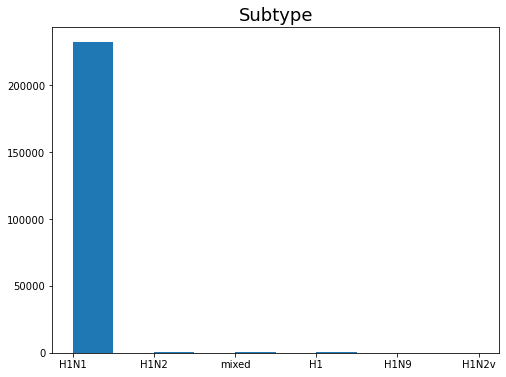

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df["Subtype"])
plt.title("Subtype", fontsize=18)
plt.show()

In [ ]:
df["Subtype"].value_counts()

H1N1     232138
mixed       664
H1N2        608
H1          557
H1N2v        72
H1N9          1
Name: Subtype, dtype: int64

Имеем очень сильный дисбаланс данных по значению целевой перменной. Тип с одним примером не будем предсказывать моделью, поскольку такой результат нельзя валидировать. Методы борьбы с дисбалансом будут рассмотрены далее а также в дальнейшим рассмторим переменные после устранения дисбаланса, пока продолжим обзор.

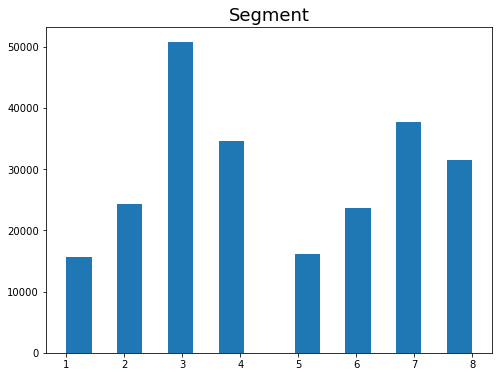

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df.sort_values(by = "Segment")["Segment"],16)
plt.title("Segment", fontsize=18)
plt.show()

По распределению переменной Segment особенностей нет

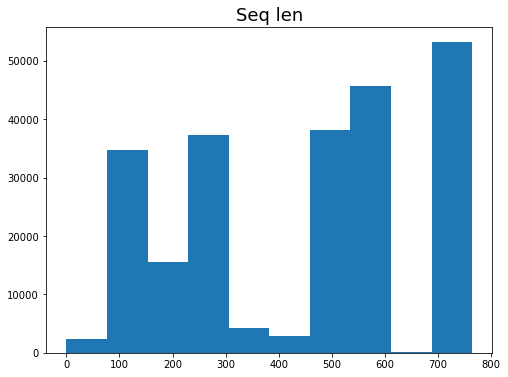

In [ ]:
#Рассмотрим длины последовательностей
plt.figure(figsize=(8,6))
plt.hist(df.sort_values(by = "seq_len")["seq_len"],10)
plt.title("Seq len", fontsize=18)
plt.show()

Видем, что последовательности имеют различную длину, имеется много оборазцов как с длинной около 100-300 едениц,так и много образцов с длинной 500-800.

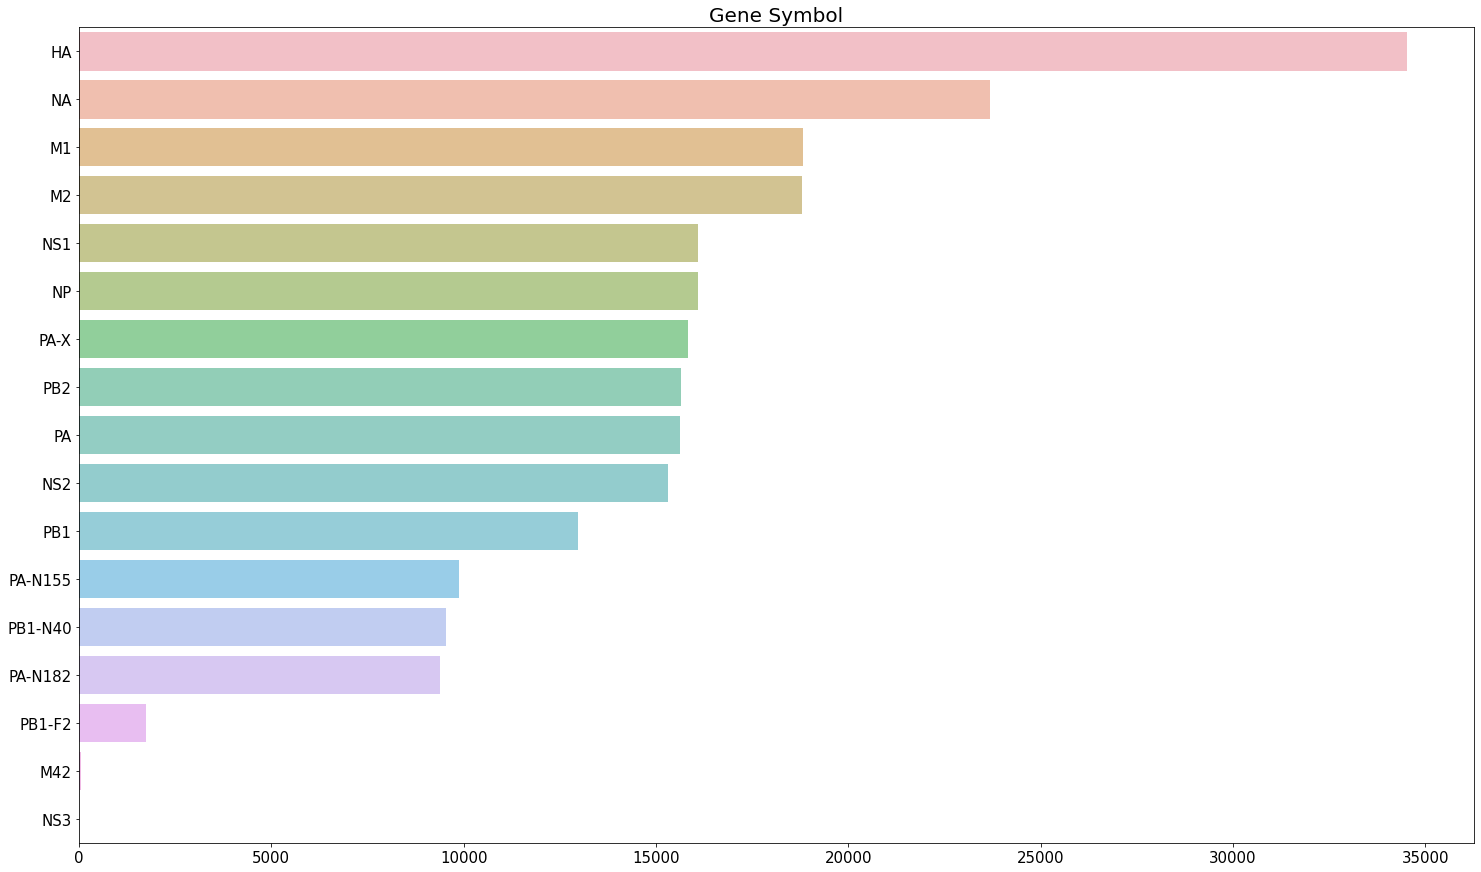

In [ ]:
gene_symblo = df['Gene Symbol'].value_counts()

plt.figure(figsize=(25,15))
plt.title("Gene Symbol", fontsize=20)
plt.tick_params(labelsize=15)

sns.barplot(y=gene_symblo.index, x=gene_symblo.values, alpha=0.6)
plt.show()

Большинство классов Gene Symbol имеют соизмеримые велечины за исключением крайне редких M42 - 50 примеров и NS3 - 2 примера, также редким является класс PB1-F2

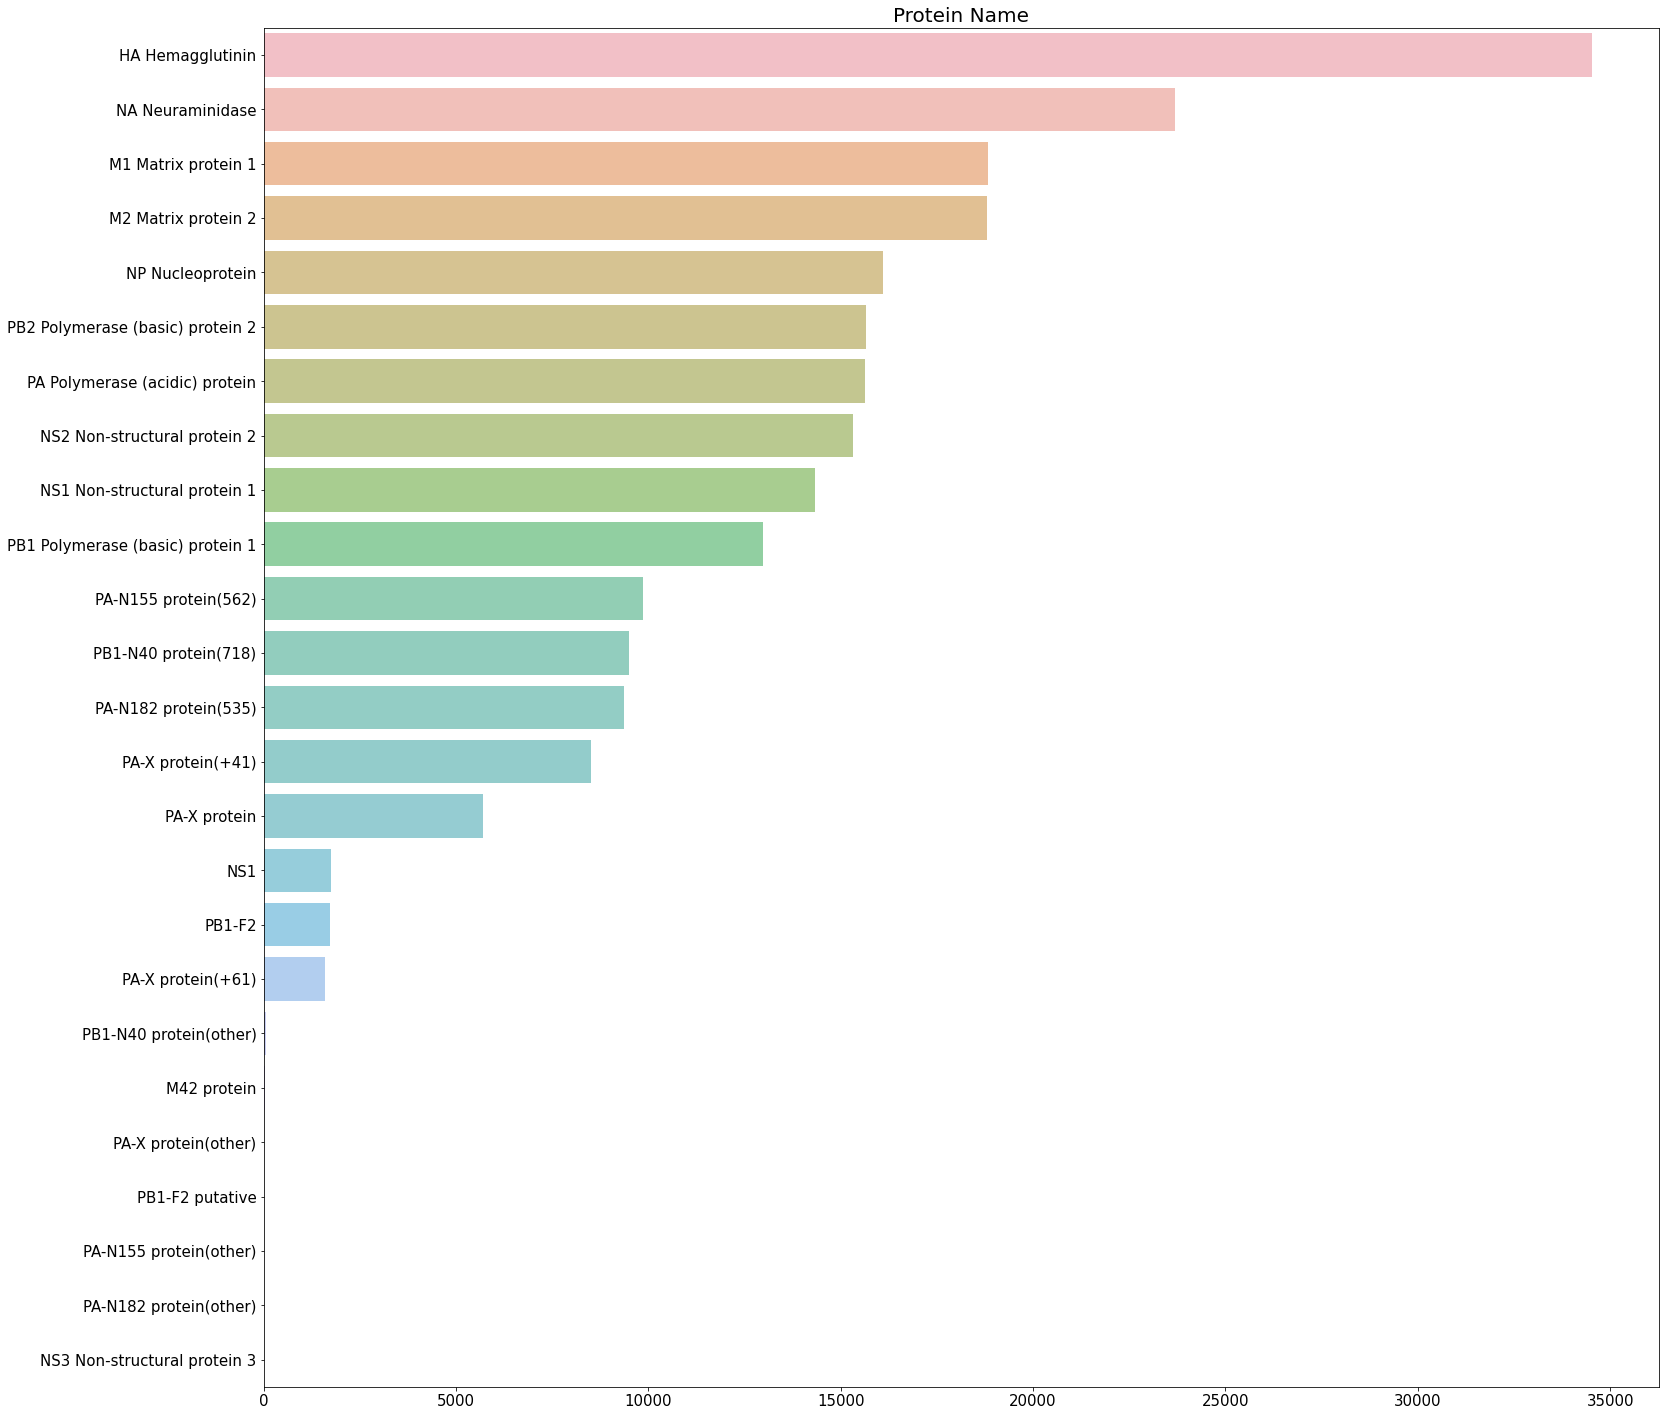

In [ ]:
#Посмотрим на очень близкую к Gene Symbol перменную - Protein Name
gene_symblo = df['Protein Name'].value_counts()

plt.figure(figsize=(25,25))
plt.title("Protein Name", fontsize=20)
plt.tick_params(labelsize=15)

sns.barplot(y=gene_symblo.index, x=gene_symblo.values, alpha=0.6)
plt.show()

Как можно видеть присутствует много крайне редких классов, в тоже информативная часть во многом аналогично предедущей переменной.

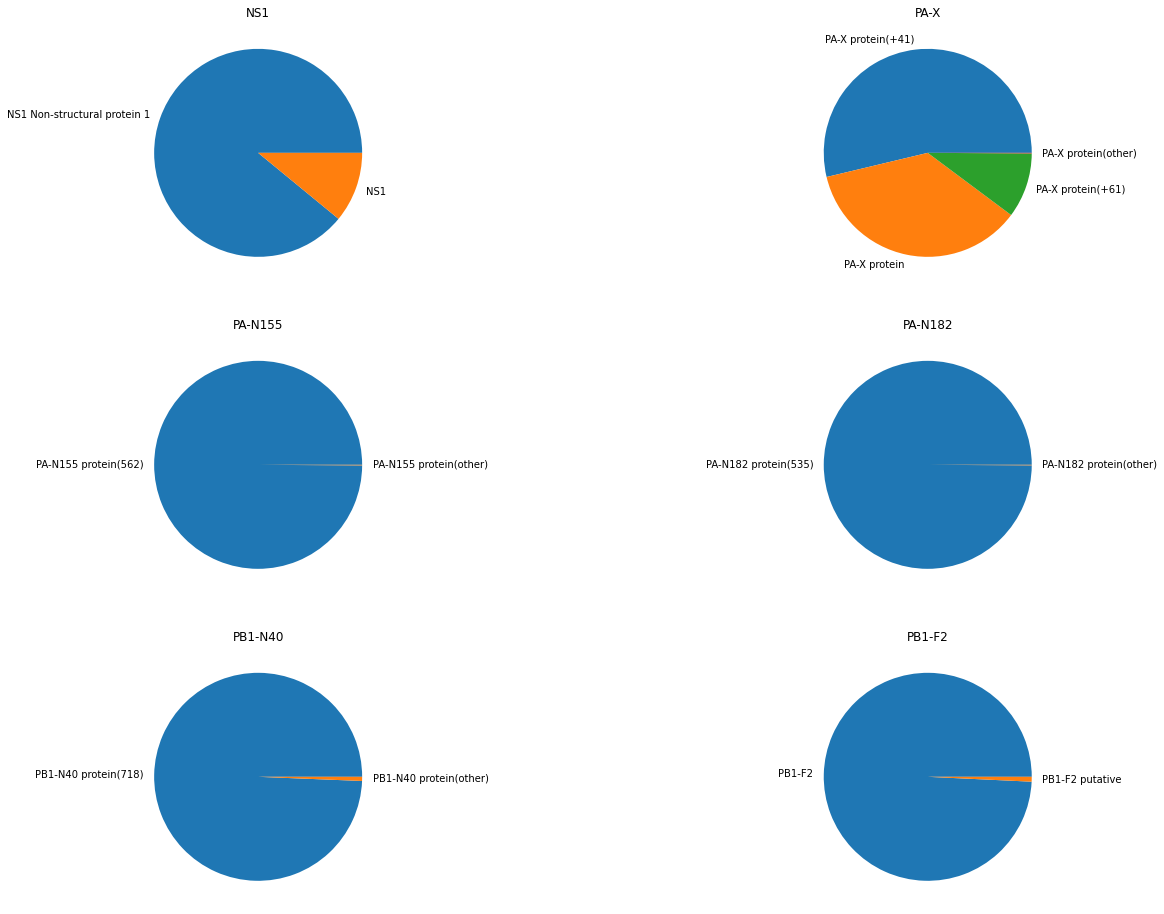

In [ ]:
#Посмотрим на отношения значений при одном Gene Symbol:
genes = df["Gene Symbol"].unique()
k = 1

fig, ax = plt.subplots()
for i in genes:
    PrN = df[df["Gene Symbol"] == i]["Protein Name"]
    if(PrN.nunique()>1):
        plt.subplot(4, 2,k)
        plt.pie(PrN.value_counts(), labels = PrN.value_counts().index)
        plt.title(label = i)
        k+=1
        
fig.set_figwidth(22)    
fig.set_figheight(22)
plt.show()

Как можно видеть по NS1 и PA-X вариации в сравнительных отношениях в отличии от остальных 4ех случаев.

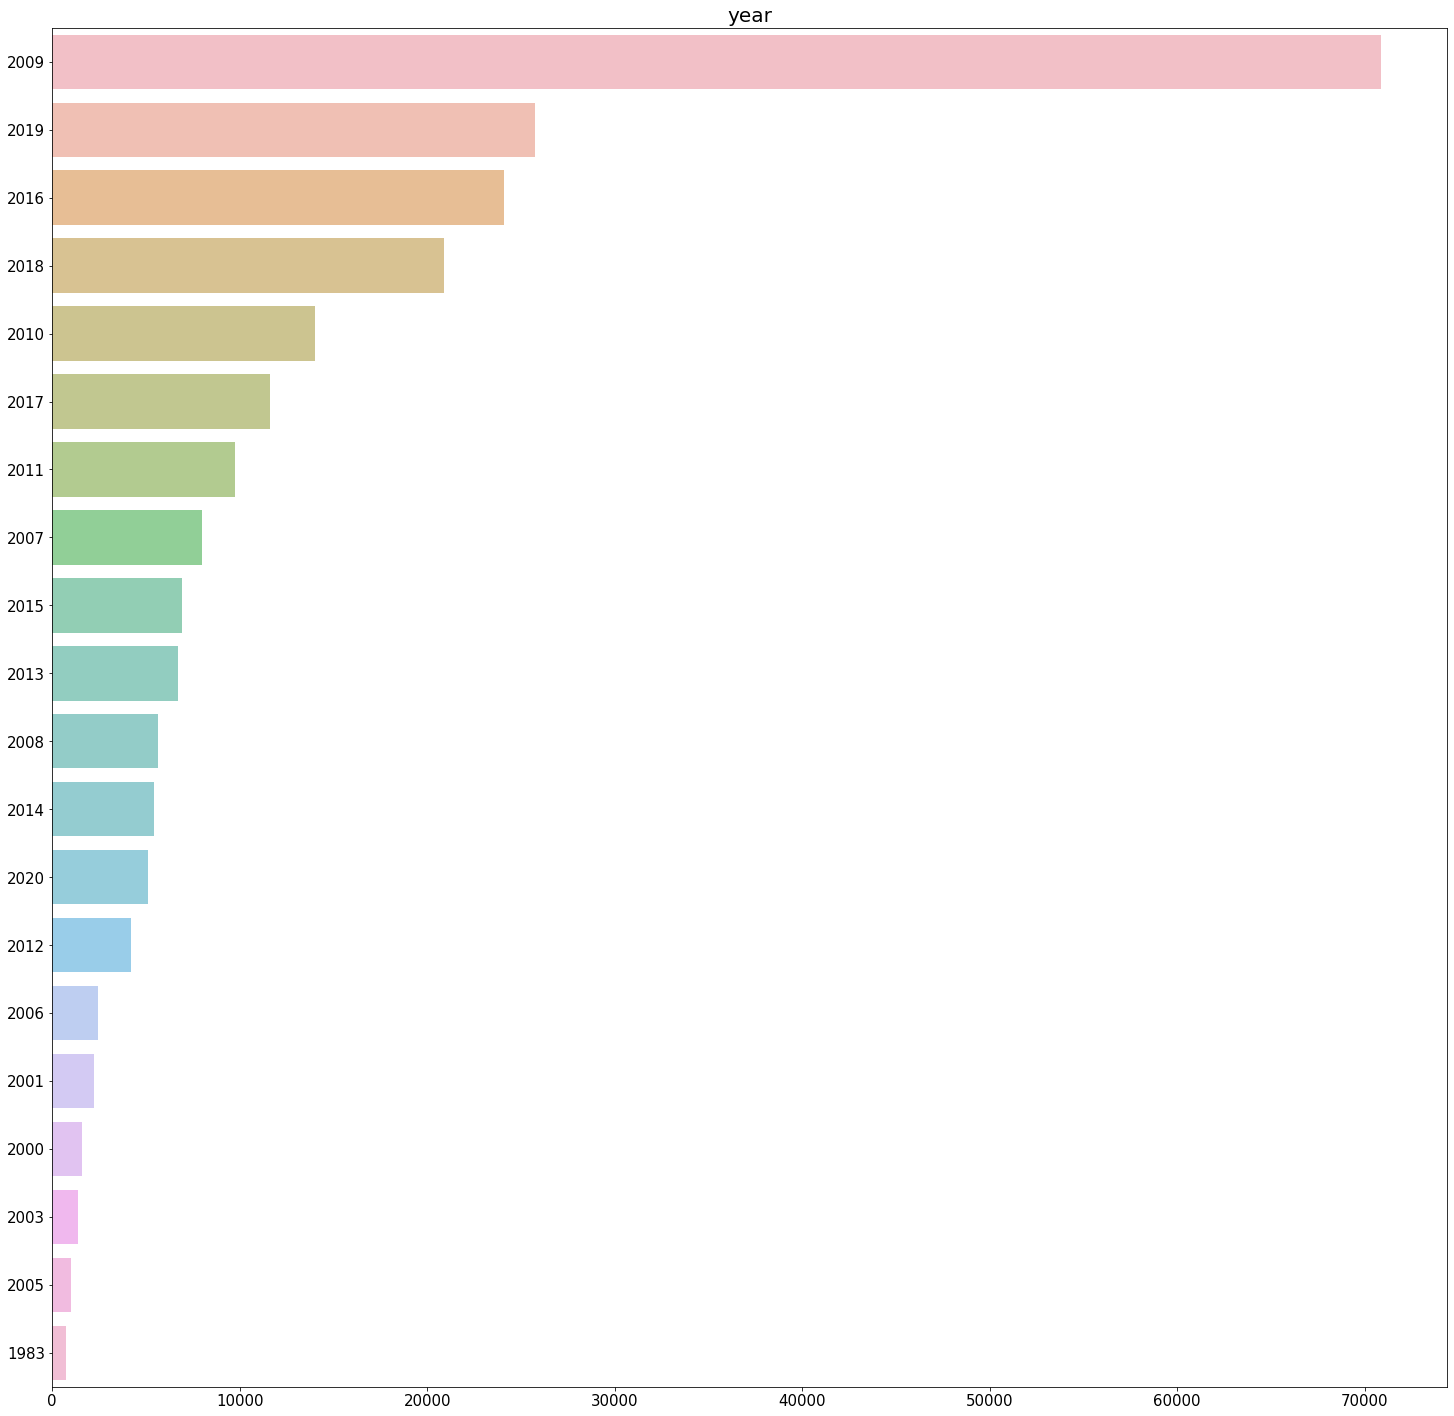

In [ ]:
#Рассмотрим дополнительную информацию как места и года сбора данных, поскольку значений очень много, рассмторим топ 20 и топ 40 соответственно
gene_symblo = df['year'].value_counts()[:20]

plt.figure(figsize=(25,25))
plt.title("year", fontsize=20)
plt.tick_params(labelsize=15)

sns.barplot(y=gene_symblo.index, x=gene_symblo.values, alpha=0.6)
plt.show()

Видно что большая часть данных была собрана в 2009 году, а также в последние 5 лет.


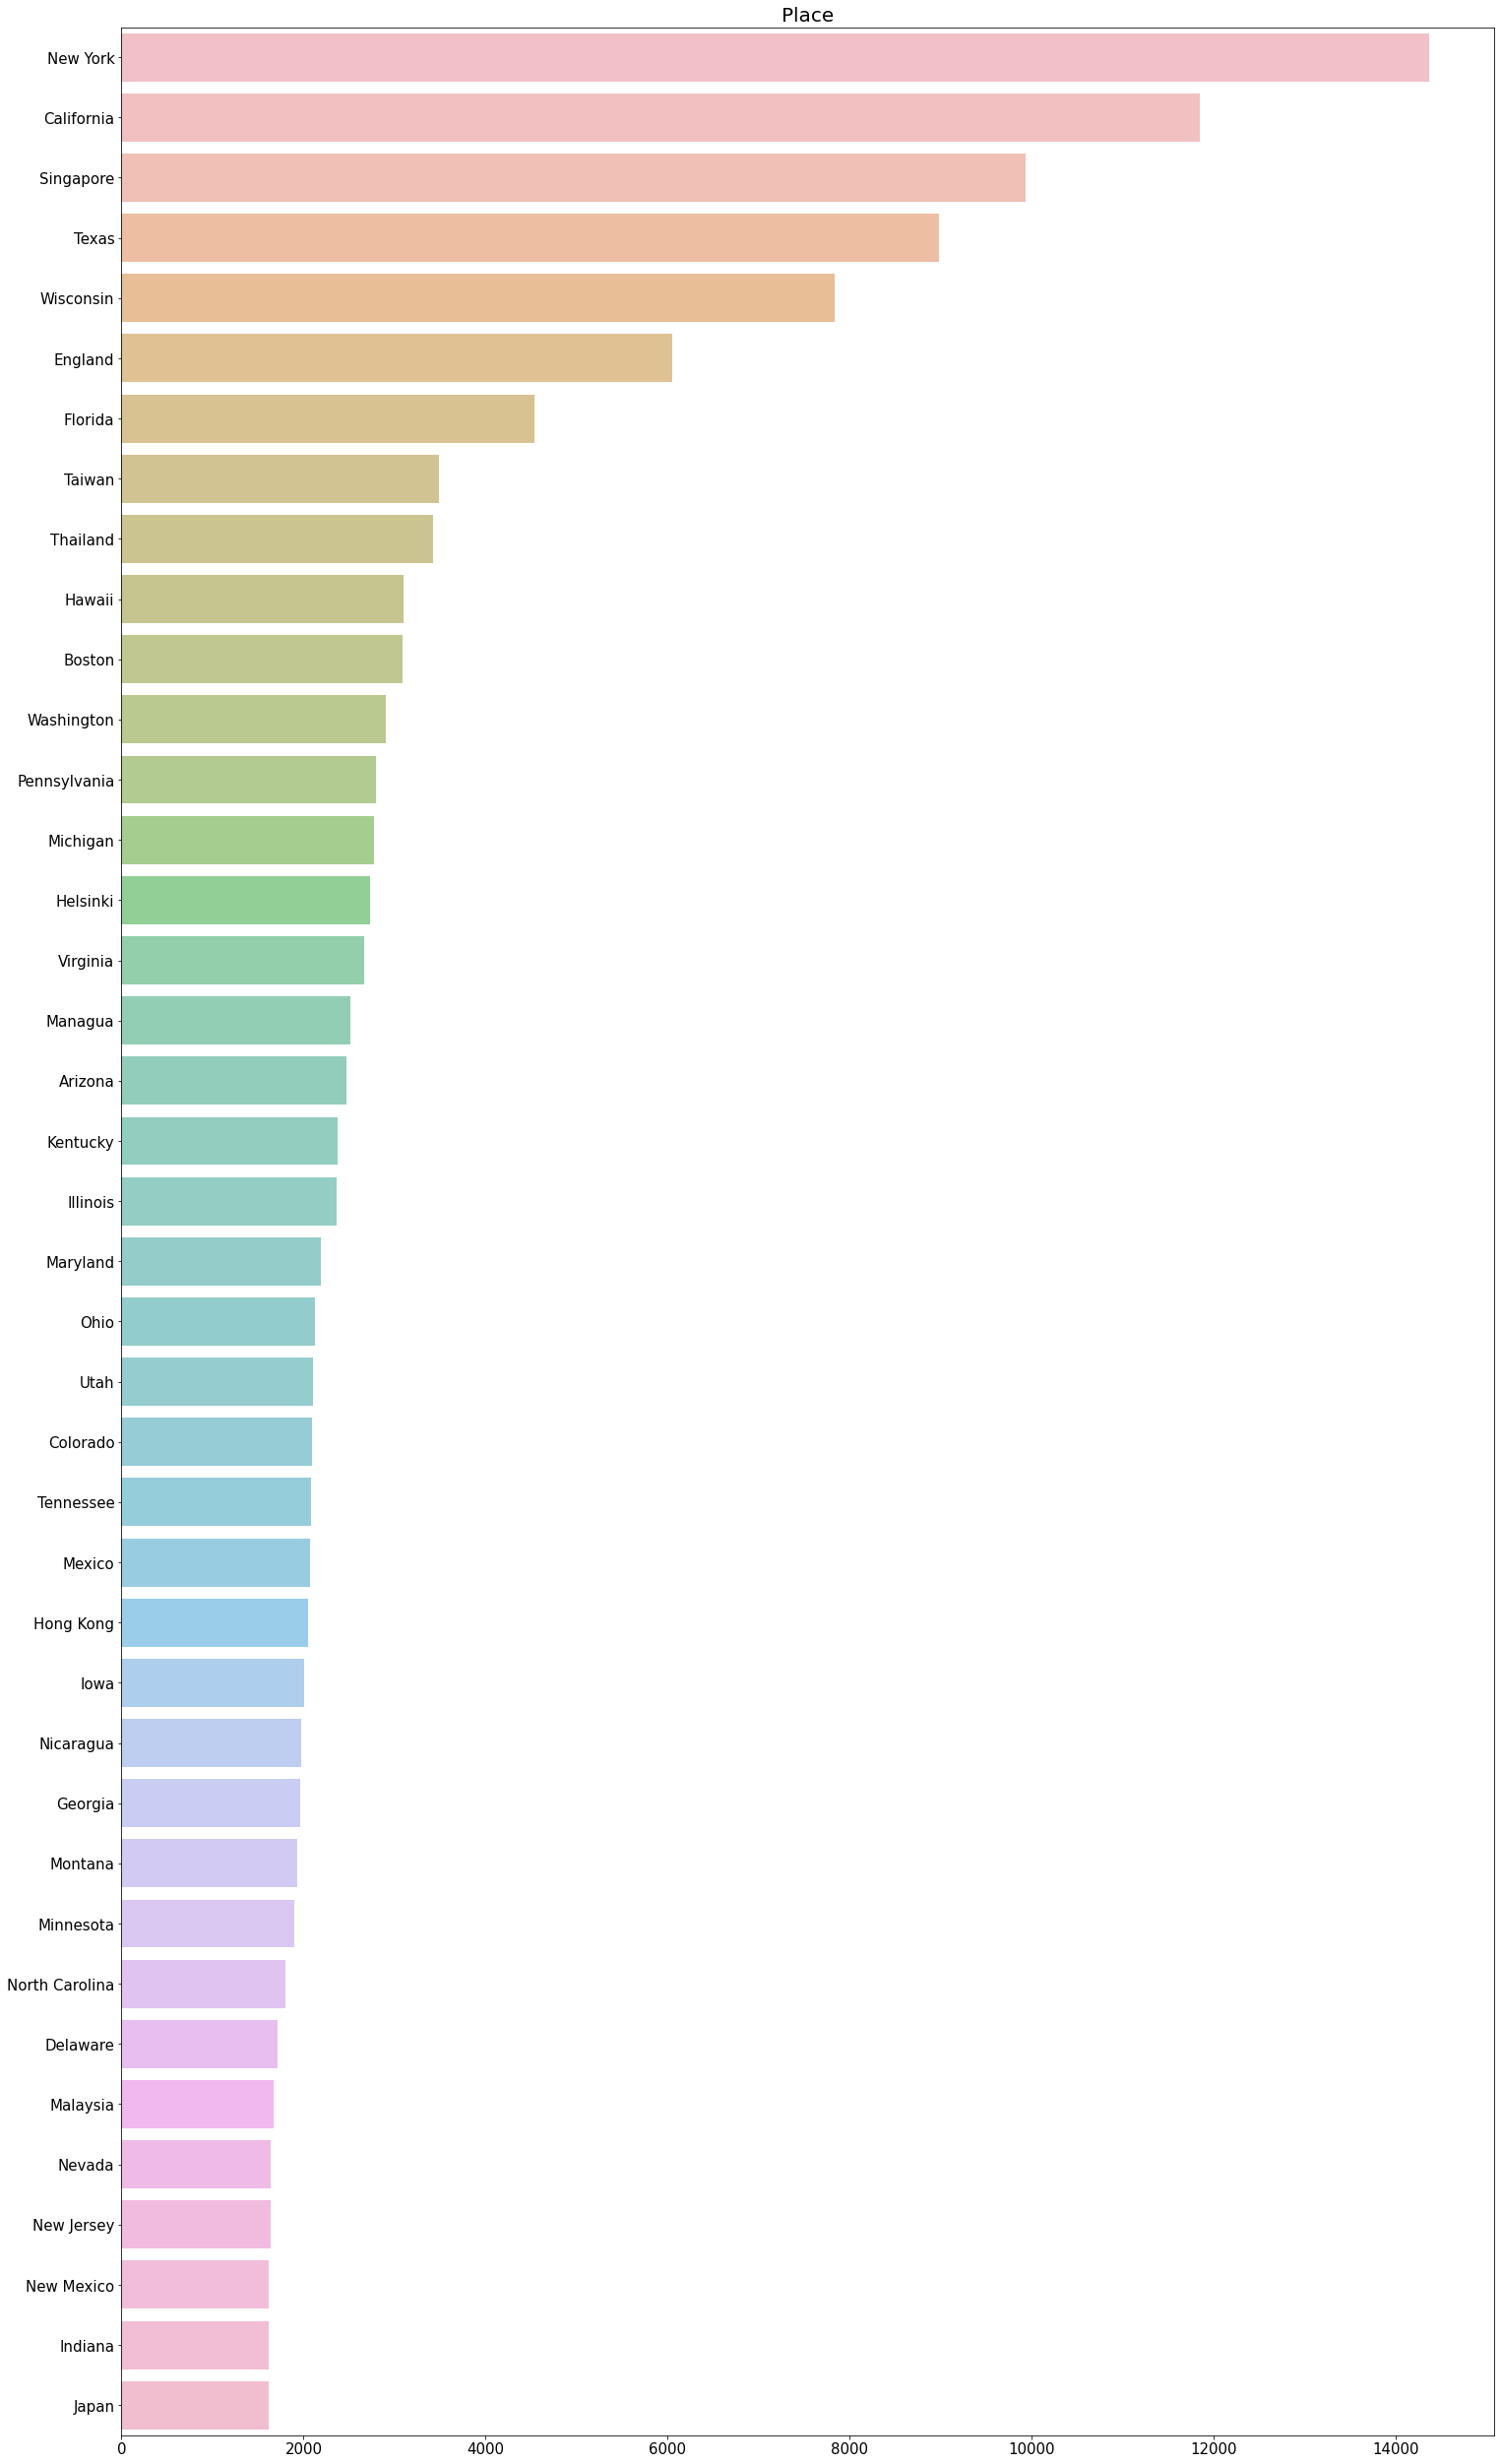

In [ ]:
gene_symblo = df['Place'].value_counts()[:40]

plt.figure(figsize=(25,45))
plt.title("Place", fontsize=20)
plt.tick_params(labelsize=15)

sns.barplot(y=gene_symblo.index, x=gene_symblo.values, alpha=0.6)
plt.show()

Из взгялда на места сразу видно что для США информация разбита по отдельынм штатам, причем обьем информации для каждого штата сопоставим с кол-вом данных для отдельных стран отличных от США, в связи с чем можно говорить о том, что большая часть данных собрана по США.

### Рассмотрим  данные в срезах по значениям целевое перменной

In [ ]:
subtypes = df["Subtype"].unique()

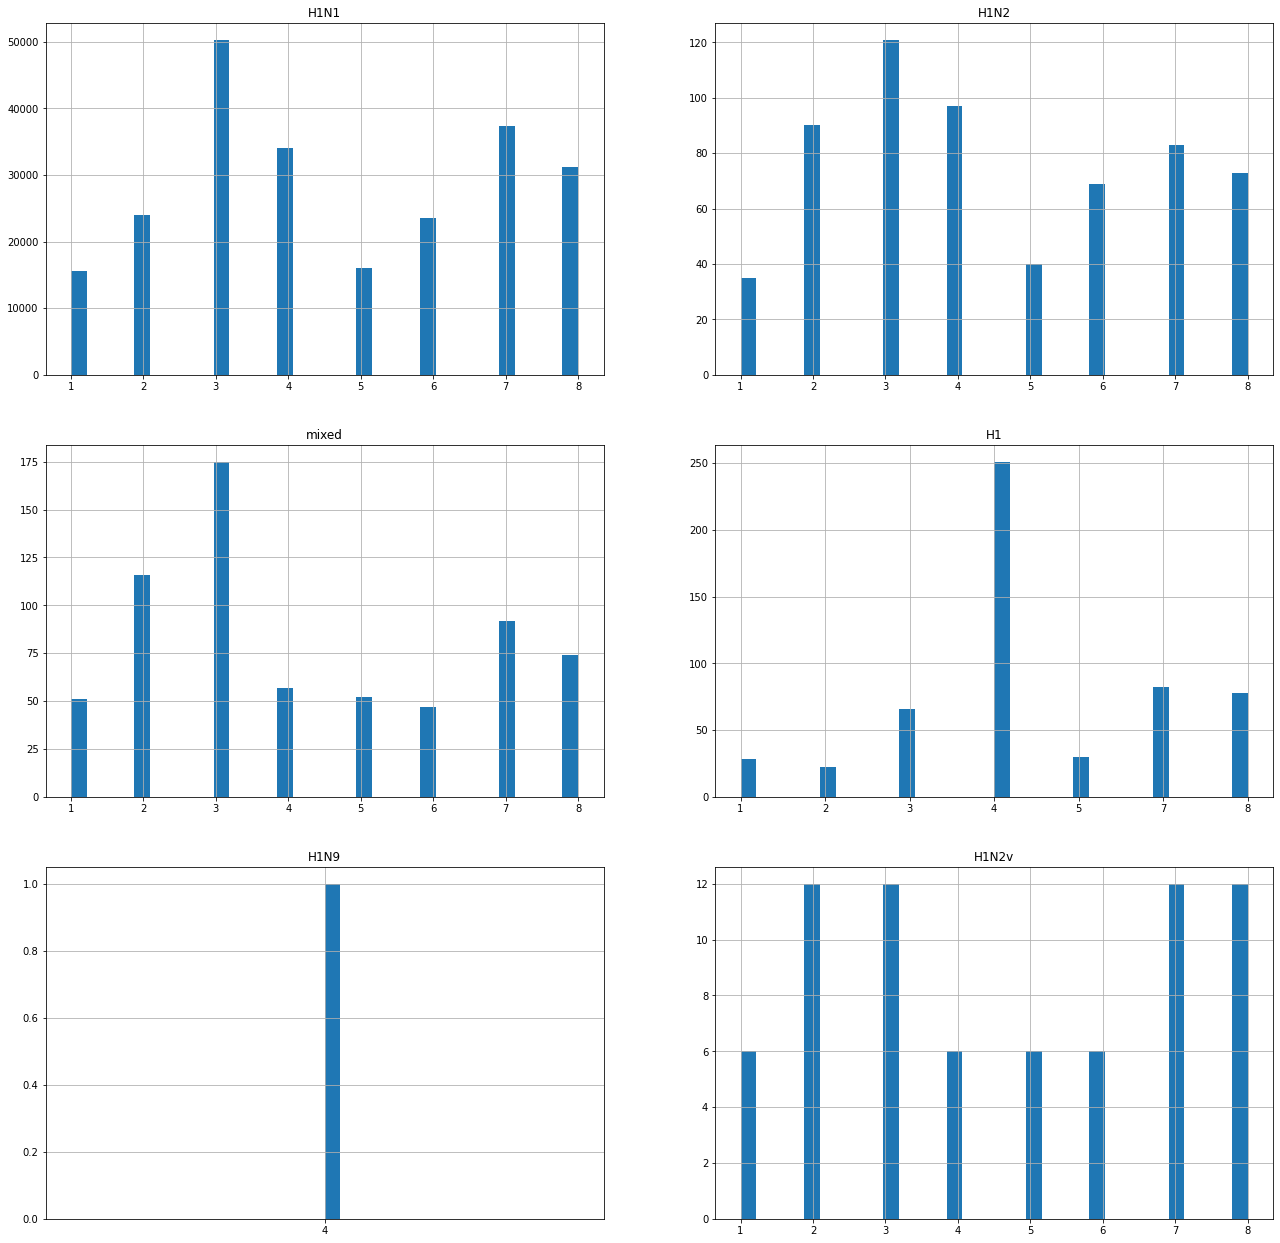

In [ ]:
#Segment
k = 1
fig, ax = plt.subplots()
for i in subtypes:
    Segments = df[df["Subtype"] == i].sort_values(by = "Segment")["Segment"]
    plt.subplot(3, 2,k)
    Segments.hist(bins=32)
    plt.title(label = i)
    k+=1
fig.set_figwidth(22)    
fig.set_figheight(22)
plt.show()

Из визуализации видно, что распределения для Segment для H1N1, H1N2, mixed и H1N2v схожи, для H1N1 и H1N2 напомниают смесь двух нормальных распределений с матожиданиеями 3 и 7. Из данных распредлений выделяется для подтипа H1 имеющее большой пик по значению 4.

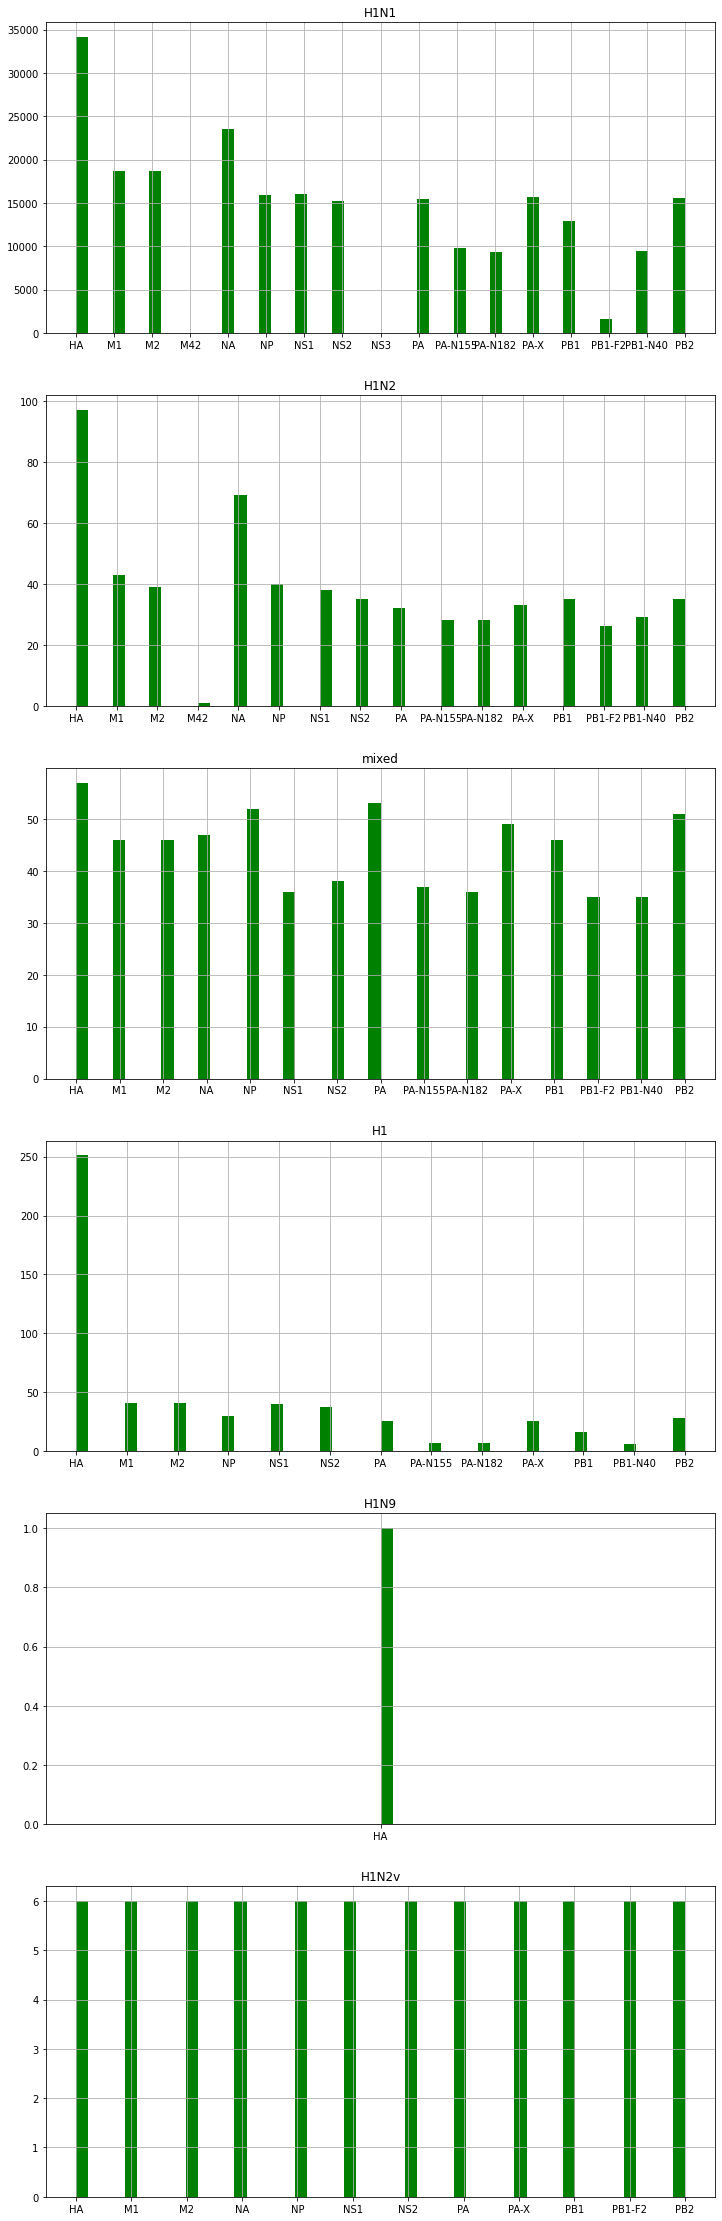

In [ ]:
#Gene Symbol
k = 1
fig, ax = plt.subplots()
for i in subtypes:
    gene = df[df["Subtype"] == i].sort_values(by = "Gene Symbol")["Gene Symbol"]
    plt.subplot(6, 1,k)
    gene.hist(bins = 50, color = "green")
    plt.title(label = i)
    k+=1
fig.set_figwidth(12)    
fig.set_figheight(40)
plt.show()

По данной переменной имеем схожую картину, распределения для H1N1 и H2N2 очень близки, в то же время H1 сильно выделяется от остальных, пиком по одному из значений.  Подтип H1N2v имеет равномерное распределение по данному параметру, для подтипа mixed получается действительно промежуточная картина между распределениями вида H1N1 и N1N2v, что также наводит на мысль что в mixed попали данные различных подтипов и от него лучше отказаться.

In [ ]:
df = df[df["Subtype"] != "mixed"] #избавимся от mixed как не от самостоятельного подтипа
df = df[df["Subtype"] != "H1N9"] #избавимся от подтипа представленного в единственном кол-ве

Теперь рассмотрим распределение Subtypes для различных генов (отбросив H1N1 из-за дисбаланса)

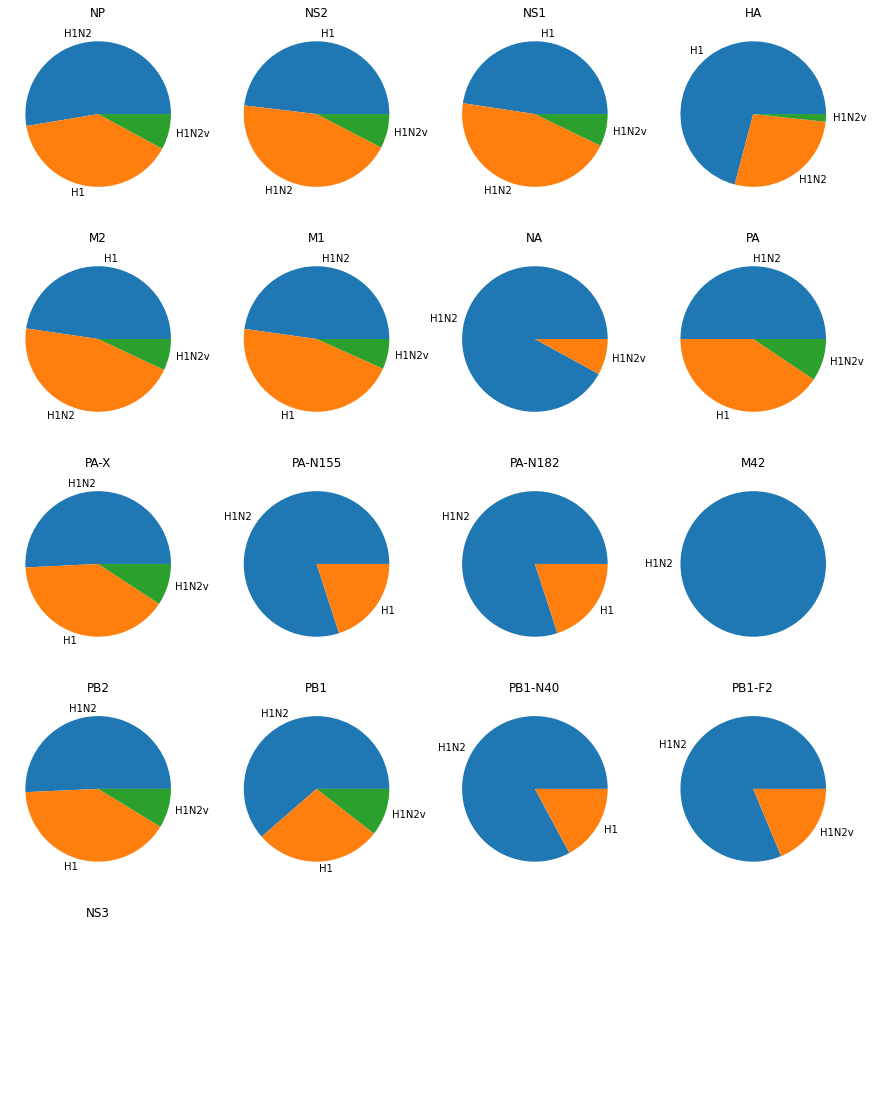

In [ ]:
#Диаграммы распределений подтипов для различных Gene Symbol
genes = df["Gene Symbol"].unique()
k = 1

fig, ax = plt.subplots()
for i in genes:
    Sub = df[df["Gene Symbol"] == i]
    Sub = Sub[Sub["Subtype"] != "H1N1"]["Subtype"]
    plt.subplot(5, 4,k)
    plt.pie(Sub.value_counts(), labels = Sub.value_counts().index)
    plt.title(label = i)
    k+=1
        
fig.set_figwidth(15)    
fig.set_figheight(20)
plt.show()

Значительная часть распредлений схожа с NP, NS1, NS2, PB2 и тд, в данной группе отношение схоже с отношением в целом содержания данных подтипов в данных. также можно выделить группу имеющих только 2 вариации подтипа, здесь наблюдается преобладание H1N2.

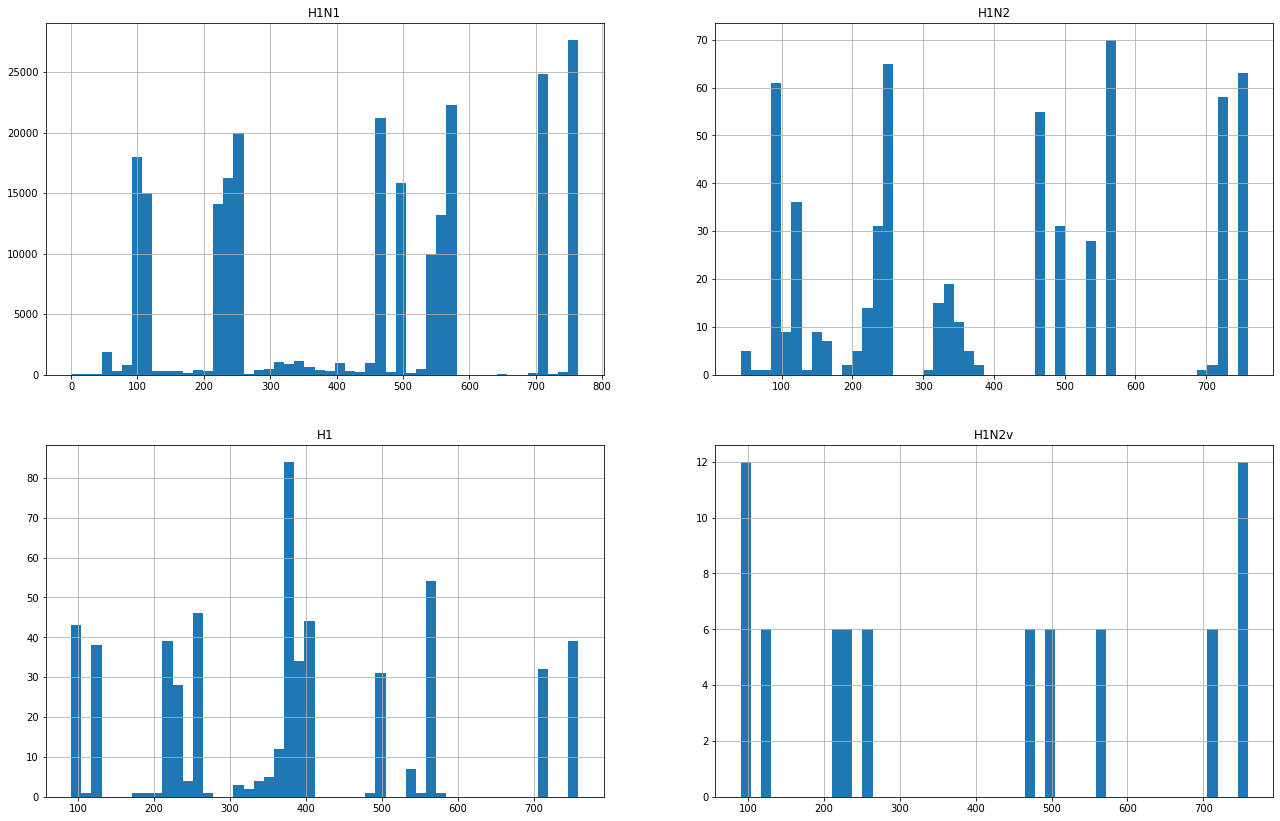

In [ ]:
#Посмотрим на распределение длин последовательностей относительно Подтипов и Сегментов.
subtypes = df["Subtype"].unique()
k = 1
fig, ax = plt.subplots()
for i in subtypes:
    Subtypes = df[df["Subtype"] == i].sort_values(by = "seq_len")["seq_len"]
    plt.subplot(3, 2,k)
    Subtypes.hist(bins=50)
    plt.title(label = i)
    k+=1
fig.set_figwidth(22)    
fig.set_figheight(22)
plt.show()

Для всех подтипов явно выделяется несколько пиков значений, соответствующих различным сегментам, а также небольшой редкий шум отклонений длин. Дополнительно убедимся в этом рассмотрев сечение по сегментам.

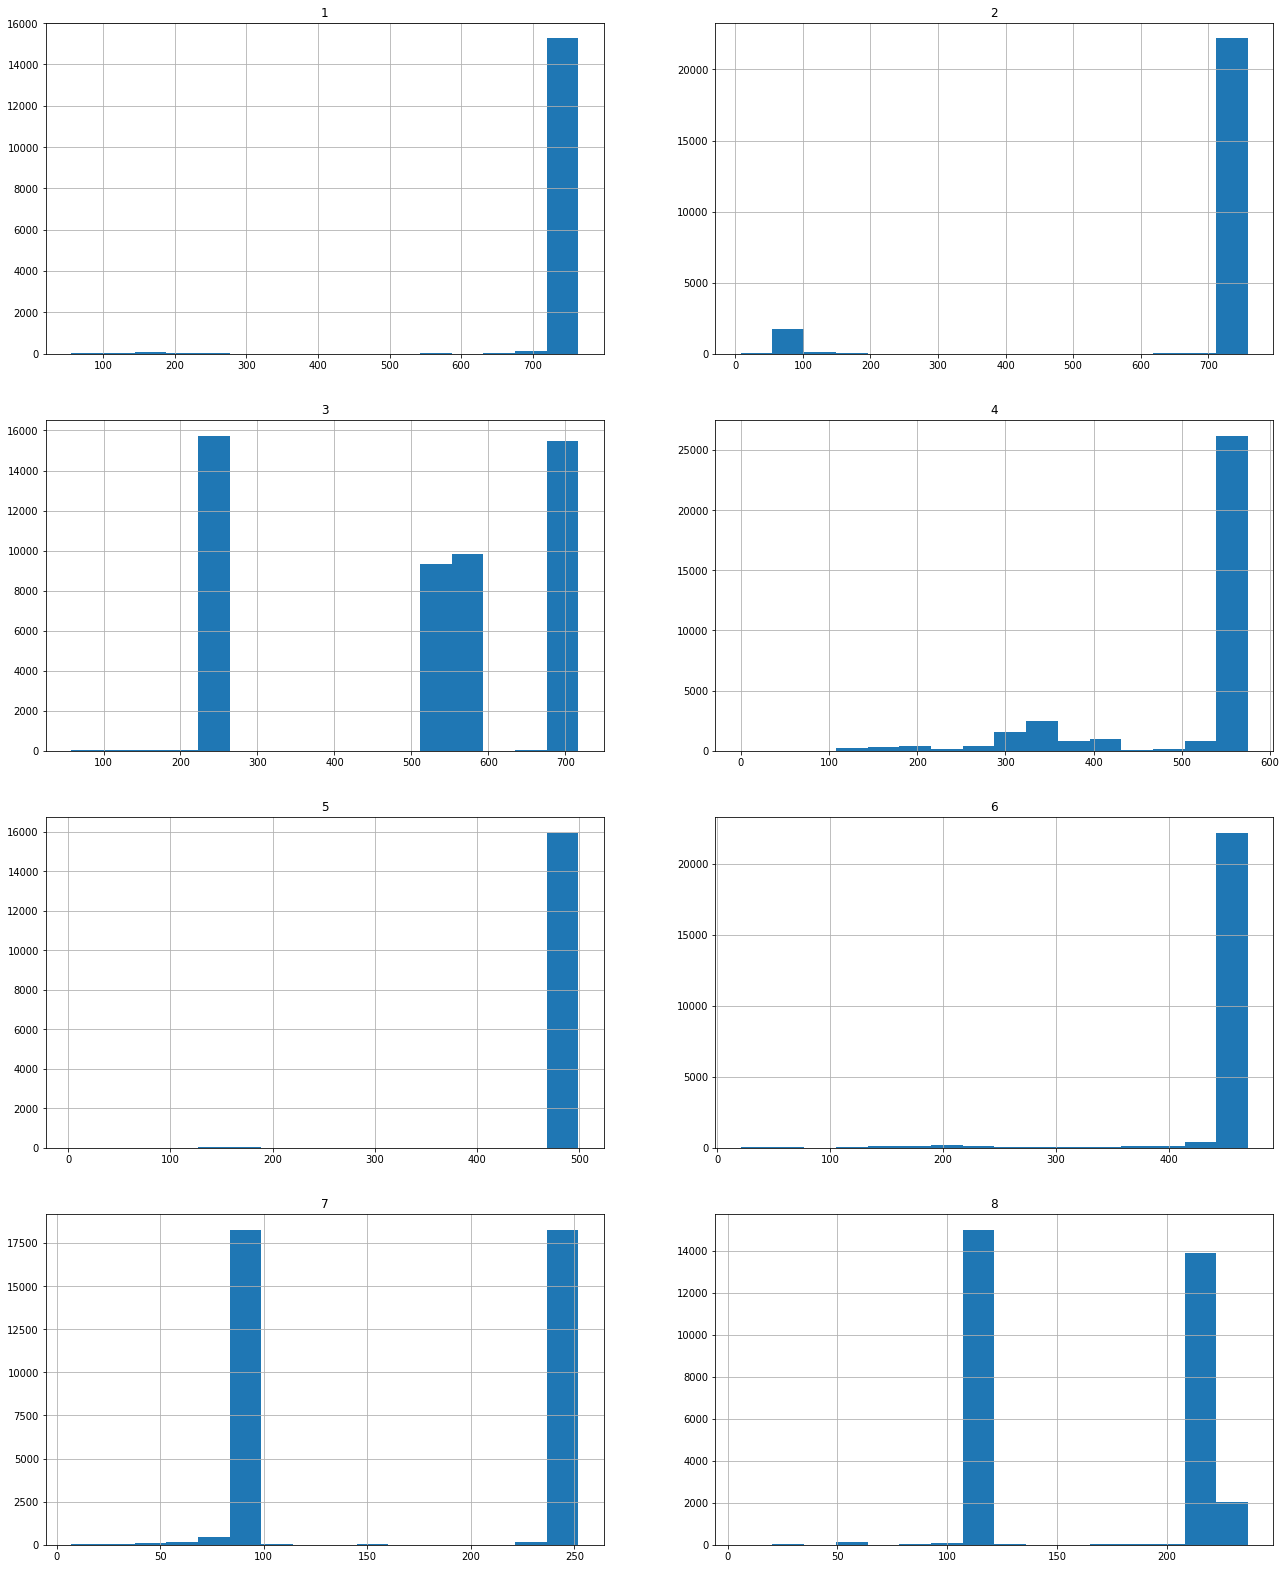

In [ ]:
segments = range(1,9)
k = 1
fig, ax = plt.subplots()
for i in segments:
    Segments = df[df["Segment"] == str(i)].sort_values(by = "seq_len")["seq_len"]
    plt.subplot(4, 2,k)
    Segments.hist(bins=16)
    plt.title(label = i)
    k+=1
fig.set_figwidth(22)    
fig.set_figheight(28)
plt.show()

Как можно видеть, разнообразие длин в сечение по сегментам значительно меньше, для каждого сегмента четко выделяется от одного до 3ех возможных значений длин, с небольшими отклоненями от каждого. 

### Проанализируем сами последовательности 

In [ ]:
import string
chars = list(string.ascii_uppercase)

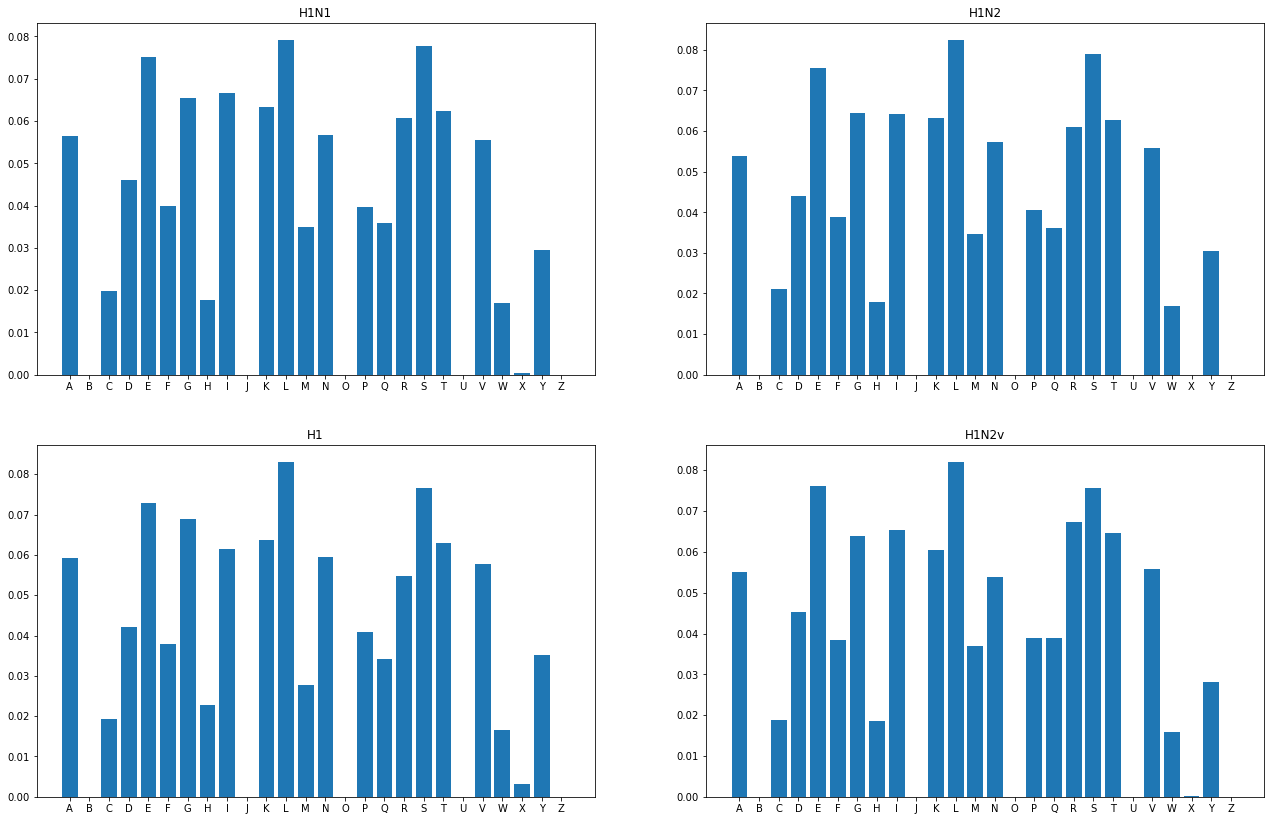

In [ ]:
#Для начала просто сравним состав последовательностей, относительно целевой перменной. 
n = 1
subtypes = df["Subtype"].unique()
fig, ax = plt.subplots()
for i in subtypes:
    seq = df[df["Subtype"] == i]["seq"]
    count = [0]*26
    for j in seq:
        for k in range(26):
            count[k] = count[k]+j.count(chars[k])
    plt.subplot(3, 2,n)
    count = np.array(count)
    plt.bar(chars,count/np.sum(count))
    plt.title(label = i)
    n+=1
fig.set_figwidth(22)    
fig.set_figheight(22)
plt.show()

In [ ]:
#Как можно видеть некоторые символы почти не встречаются, после этого была сверена таблица аминокислот, стало ясно что данные символы ошибочны
#и далее символы B,X,J,O,U,Z будут интерпретироваться как один символ "неизвестная аминокислота".

Как можно видеть по общему процентному составу все подклассы очень схожи, следовательно ключевым является именно порядок последовательности.

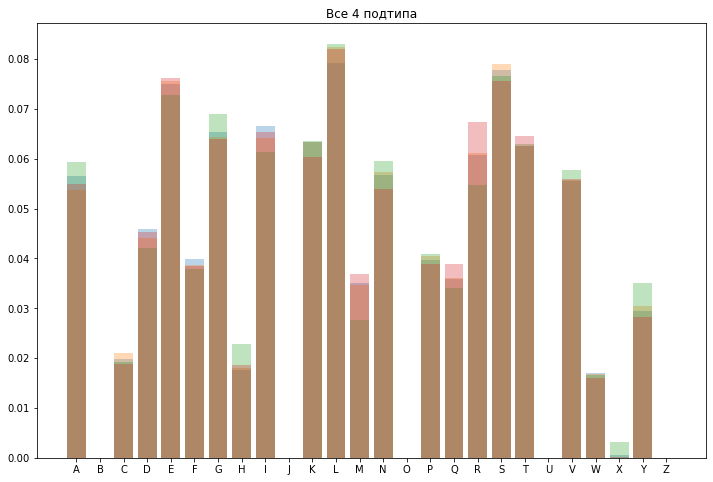

In [ ]:
#Для наглядности сходства посомтрим на наложенные диаграммы, небольшая заметная особенность есть только по X.
subtypes = df["Subtype"].unique()
fig, ax = plt.subplots()
for i in subtypes:
    seq = df[df["Subtype"] == i]["seq"]
    count = [0]*26
    for j in seq:
        for k in range(26):
            count[k] = count[k]+j.count(chars[k])
    count = np.array(count)
    plt.bar(chars,count/np.sum(count),alpha = 0.3)
    plt.title("Все 4 подтипа")
fig.set_figwidth(12)    
fig.set_figheight(8)
plt.show()

Для сравнения близости последовательностей воспользуемся стандартным подходом в данной предметной области - выравниванием, для этого будем использовать библиотеку Biopython.

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import Align
aligner = Align.PairwiseAligner()

Посмотрим на score для лучшего варыванивания пар последовательностей между представителями одного подтипа но разных сегментов.

In [ ]:
seq = df[df["Subtype"] == "H1N2"][["seq","Segment"]]
same = []
other = []
l = len(seq)
for i in range(l):
    for j in range(i):
        seq1 = seq["seq"][int(seq.index[i])]
        seq2 = seq["seq"][int(seq.index[j])]
        seg1 = seq["Segment"][int(seq.index[i])]
        seg2 = seq["Segment"][int(seq.index[j])]
        if(seg1 == seg2):
            same.append(aligner.score(seq1,seq2))
        else:
            other.append(aligner.score(seq1,seq2))

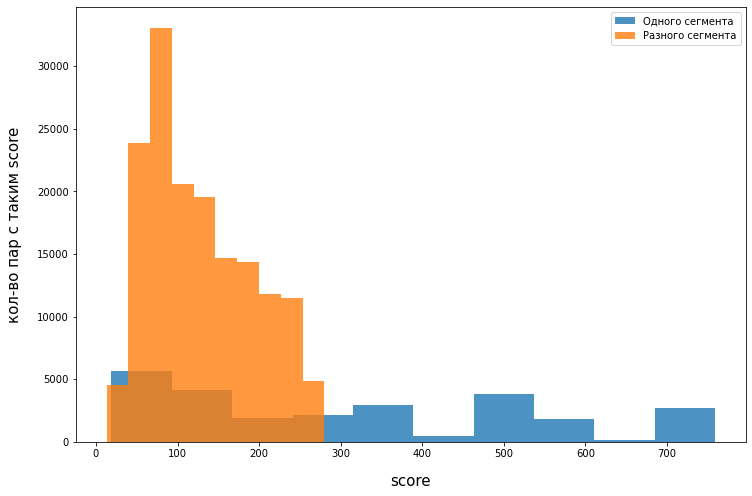

In [ ]:
fig, ax = plt.subplots()
plt.hist(same, alpha = 0.8, label = "Одного сегмента")
plt.hist(other, alpha = 0.8, label = "Разного сегмента")
fig.set_figwidth(12)    
fig.set_figheight(8)
ax.set_xlabel("score",  fontsize=15,labelpad=15)
ax.set_ylabel("кол-во пар с таким score",  fontsize=15,labelpad=15)
ax.legend()
plt.show()

Как можно видеть, score для чужих значений сконцентрирован на низком уровне, относительно score для одного сгемента

Поскольку значение score связанно с длинной посл, которая различна, попробуем ее пронормировать, деля на длину меньшей последовательности, данная нормировка должна завышать score, когда последовательности сильно отличаются по длине, например взяв последовательность из одного значения, оно с очень высокой вероятностью будет содержаться и в других последовательностях => после выравнивания получим score 1 и после нормировки также 1, что явно не обьективно, но попробуем рассмотреть данный "худший случай"

In [ ]:
seq = df[df["Subtype"] == "H1N2"][["seq","Segment"]]
sameN = []
otherN = []
l = len(seq)
for i in range(l):
    for j in range(i):
        seq1 = seq["seq"][int(seq.index[i])]
        seq2 = seq["seq"][int(seq.index[j])]
        seg1 = seq["Segment"][int(seq.index[i])]
        seg2 = seq["Segment"][int(seq.index[j])]
        if(seg1 == seg2):
            sameN.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))
        else:
            otherN.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))

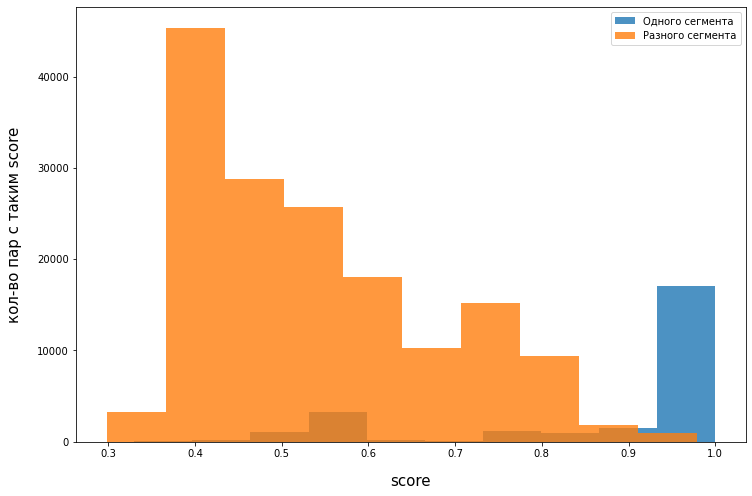

In [ ]:
fig, ax = plt.subplots()
plt.hist(sameN, alpha = 0.8, label = "Одного сегмента")
plt.hist(otherN, alpha = 0.8, label = "Разного сегмента")
fig.set_figwidth(12)    
fig.set_figheight(8)
ax.set_xlabel("score",  fontsize=15,labelpad=15)
ax.set_ylabel("кол-во пар с таким score",  fontsize=15,labelpad=15)
ax.legend()
plt.show()

После нормировки для генов одного типа явно выделилось преобладание около максимального значения, с небольшими отклоненями, в тоже время для различных сегментов score также остался на низком уровне. Такой результат был получен в "худшем" случаи. Это подтверждает наличие зависимости схожести последовательностей от сегмента. На основе этого результат возможно стоит учитывать в модели параметр Segment.

Теперь Проведем аналогичный эксперемент для последовательностей одного сегмента, но разных подтипов, тк подтип является целевой перменной.

In [ ]:
#для упрощения вычислений возьмем небольшую подвыборку по Subtype 
df4 = df[df["Segment"] == '4']
dfS4 = pd.concat([df4[df4["Subtype"] == "H1N1"][:90],df4[df4["Subtype"] == "H1N2"][:90],df4[df4["Subtype"] == "H1N2v"][:90],df4[df4["Subtype"] == "H1"][:90]])

df7 = df[df["Segment"] == '7']
dfS7 = pd.concat([df7[df7["Subtype"] == "H1N1"][:90],df7[df7["Subtype"] == "H1N2"][:90],df7[df7["Subtype"] == "H1N2v"][:90],df7[df7["Subtype"] == "H1"][:90]])

df3 = df[df["Segment"] == '3']
dfS3 = pd.concat([df3[df3["Subtype"] == "H1N1"][:90],df3[df3["Subtype"] == "H1N2"][:90],df3[df3["Subtype"] == "H1N2v"][:90],df3[df3["Subtype"] == "H1"][:90]])

In [ ]:
seq = dfS4[["seq","Subtype"]]
sameS4 = []
otherS4 = []
l = len(seq)
for i in range(l):
    for j in range(i):
        seq1 = seq["seq"][int(seq.index[i])]
        seq2 = seq["seq"][int(seq.index[j])]
        sub1 = seq["Subtype"][int(seq.index[i])]
        sub2 = seq["Subtype"][int(seq.index[j])]
        if(sub1 == sub2):
            #sameS.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))
            sameS4.append(aligner.score(seq1,seq2))
        else:
            #otherS.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))
            otherS4.append(aligner.score(seq1,seq2))
seq = dfS7[["seq","Subtype"]]
sameS7 = []
otherS7 = []
l = len(seq)
for i in range(l):
    for j in range(i):
        seq1 = seq["seq"][int(seq.index[i])]
        seq2 = seq["seq"][int(seq.index[j])]
        sub1 = seq["Subtype"][int(seq.index[i])]
        sub2 = seq["Subtype"][int(seq.index[j])]
        if(sub1 == sub2):
            #sameS.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))
            sameS7.append(aligner.score(seq1,seq2))
        else:
            #otherS.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))
            otherS7.append(aligner.score(seq1,seq2))
            
seq = dfS3[["seq","Subtype"]]
sameS3 = []
otherS3 = []
l = len(seq)
for i in range(l):
    for j in range(i):
        seq1 = seq["seq"][int(seq.index[i])]
        seq2 = seq["seq"][int(seq.index[j])]
        sub1 = seq["Subtype"][int(seq.index[i])]
        sub2 = seq["Subtype"][int(seq.index[j])]
        if(sub1 == sub2):
            #sameS.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))
            sameS3.append(aligner.score(seq1,seq2))
        else:
            #otherS.append(aligner.score(seq1,seq2)/np.min([len(seq1),len(seq2)]))
            otherS3.append(aligner.score(seq1,seq2))

Посмотрим на score для одинаковых и различных подтипов с одинаковым значением Segment.

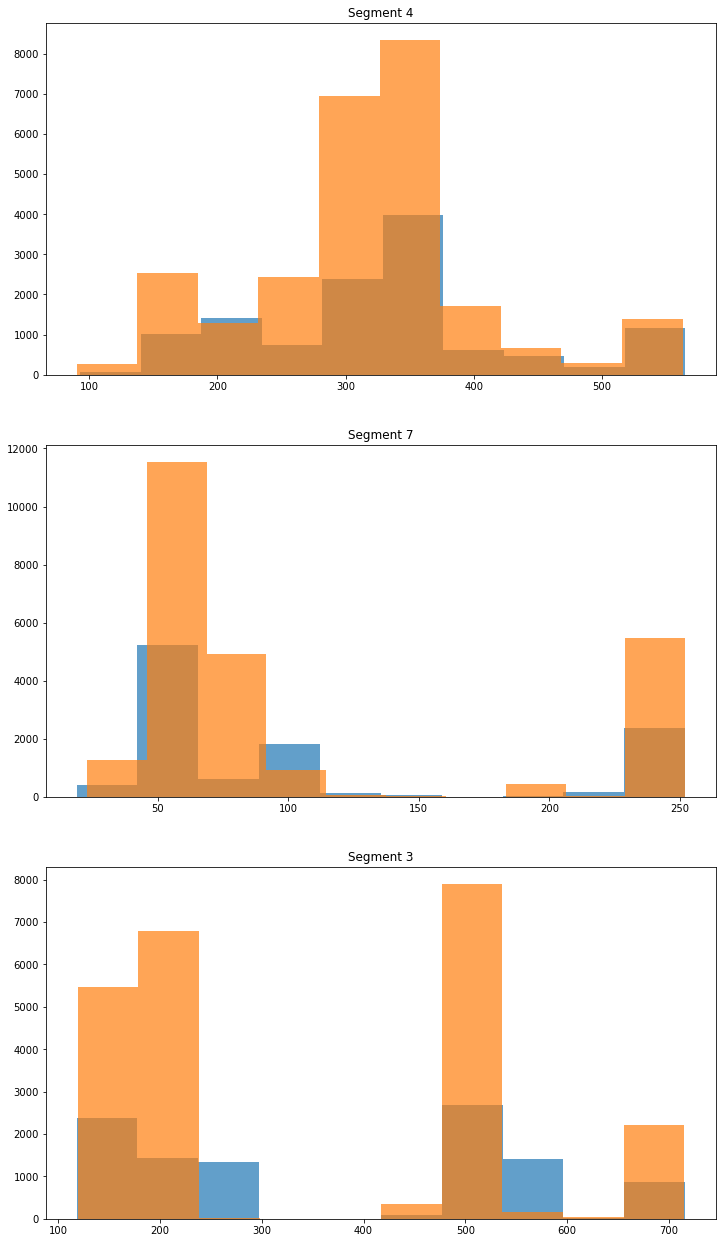

In [ ]:
fig, ax = plt.subplots()
plt.subplot(3,1,1)
plt.hist(sameS4, alpha = 0.7, label = "Одного типа")
plt.hist(otherS4, alpha = 0.7, label = "Разного типа")
plt.title("Segment 4")

plt.subplot(3,1,2)
plt.hist(sameS7, alpha = 0.7, label = "Одного типа")
plt.hist(otherS7, alpha = 0.7, label = "Разного типа")
plt.title("Segment 7")

plt.subplot(3,1,3)
plt.hist(sameS3, alpha = 0.7, label = "Одного типа")
plt.hist(otherS3, alpha = 0.7, label = "Разного типа")
plt.title("Segment 3")

fig.set_figwidth(12)    
fig.set_figheight(22)
plt.show()

In [ ]:
#В данном случаи необходимо смотреть на сами распределения а не на абсолютыне значения диграммы
#Поскольку сочетаний пар для одного и разных подтипов различно

Рассматривая данные распредления видно, что значимых различий между последовательностями одного сегмента, но различных подтипов при таком способе сравнения не наблюдается. Это говорит о том, что подтипы сложно разделимы и обосновывает использование моделей машинного обучения для решения данной задачи.

In [ ]:
res = []
subs = df["Subtype"].unique()
for i in range(1,9): 
    dfi = df[df["Segment"] == str(i)]
    dfSi = pd.concat([dfi[dfi["Subtype"] == "H1N1"][:90], dfi[dfi["Subtype"] == "H1N2"][:90], dfi[dfi["Subtype"] == "H1N2v"][:90], dfi[dfi["Subtype"] == "H1"][:90]])
    res_seg = []
    seq = dfSi[["seq","Subtype"]]
    for s in range(4):
        res_sub = []
        seqS = dfSi[dfSi["Subtype"] == subs[s]]
        for i in range(len(seqS)):
            for j in range(i):
                seq1 = seqS["seq"][int(seqS.index[i])]
                seq2 = seqS["seq"][int(seqS.index[j])]
                res_sub.append(aligner.score(seq1,seq2))
        res_seg.append(res_sub)
    res.append(res_seg)

Сравним дисперсии для близостей внтури одоного сегмента и подтипа, чтобы оценить вариабильность различных последовательностей. (Сделаем нормировку по масштабу в отрезок [0,1] для каждого вида)

In [ ]:
#Отсутствующие значения заменим на -0.1
M = []
for i in res:
    segm = []
    for j in i:
        if(len(j)>0):
            segm.append(np.var(j/np.max([j])))
        else:
            segm.append(-0.1)
    M.append(segm)
M = np.array(M)
M = pd.DataFrame(M, index = range(1,9), columns = subs)

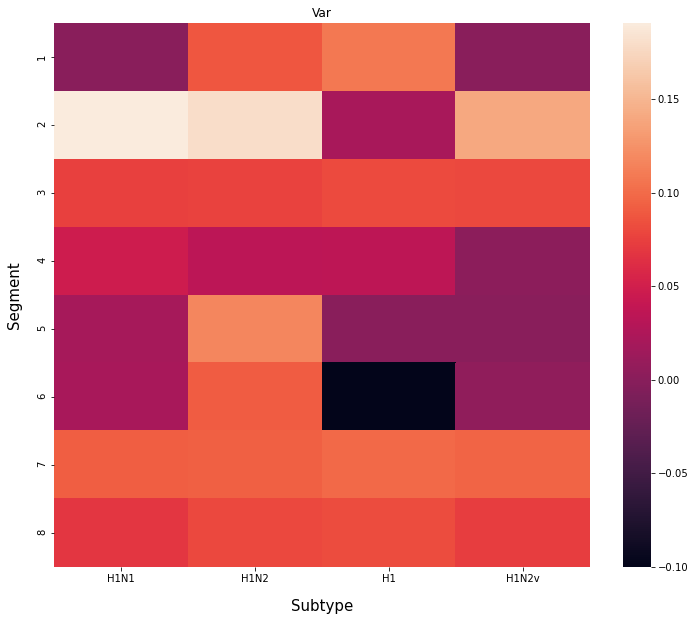

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(M)
fig.set_figwidth(12)    
fig.set_figheight(10)
ax.set_xlabel("Subtype",  fontsize=15,labelpad=15)
ax.set_ylabel("Segment",  fontsize=15,labelpad=15)
plt.title("Var")
plt.show()

Как можно видеть разброс значений score очень различен в рамках одного подтипа и более стабилен по одному сегменту. Также можно заметить заметный разброс значений var для 1 и 2ого сегмента, вернувшись к предедущим графикам, можно заметить что данный сегмент бывает достаточно редким, в связи с чем такое поведение может бысть связанно с малым кол-вом примеров, в тоже время наиболее стабильное значение как раз по 3 7 и 8 сегментами, которые являются наиболее частыми для всех подтипов. Данные результаты также говорят о схожести данных в рамках одного сегмента и большей сложности задачи определения подтипа.

# Построение Модели

В качестве архитектуры попробуем использовать простую bi-LSTM модель, поскольку рекурентные нейронные сети хорошо решают задачи с последовательностями, но при этом наш обьем данных невелик и оубчать тяжелую модель смысла нет.

In [ ]:
df["Subtype"].value_counts()

H1N1     232138
H1N2        608
H1          557
H1N2v        72
Name: Subtype, dtype: int64

Первым делом необходимо решить вопорос с дисбалансом классов, простейшим вариантом будет применить under sampling к преобладающему подтипу. Выберем случайным образом сопоставимое кол-во образцов подтипа H1N1. Также выделяется сравнительно малое кол-во обьектов классов H1N2v. Кол-во обьектов класса H1N2v составляет около 12% от кол-ва обьектов классов H1N2 / H1, что является нижней допустимой границей (обычно к дисбалансу требующиму мер относят значение менее 10%). 

In [542]:
#Выберем случайные данные подтипа H1N1
h1n1 = np.random.choice(df[df["Subtype"] == "H1N1"]["seq"],620)
h1n2 = df[df["Subtype"] == "H1N2"]["seq"].values
h1n2v = df[df["Subtype"] == "H1N2v"]["seq"].values
h1 = df[df["Subtype"] == "H1"]["seq"].values

Также необходимо решить вопрос представления данных последовательностей аминокислот. Возможны 2 варианта кодирования символов: кодирование самим индексом или же его one_hot представлением, попробуем использовать первый способ, чтобы не увеличивать размерность данных, правда тогда мы вносим порядок в обозначения аминокислот, что может являться минусом. Также добавим символ начала во все строки и применим падинг, для выравнивания длин всех строк, чтобы данные можно было удобно представить ввиде матрицы.

In [486]:
errors = ["X","J","U","O","Z","B"]

In [463]:
chars = list(string.ascii_uppercase)
for i in errors:
  chars.remove(i)
chars.append("X")
len(chars) #проверка алфавита (должно быть 20 аминокислот и 1 спец символ для неизвестного значения)

21

In [464]:
chars.insert(0,"!") #Стартовый символ 
chars.append("#") #Символ для падинга

In [487]:
l = df["seq_len"].max()+1 #длина строк для падинга 

In [ ]:
def one_hot_seq(seq, l = l, vocab = chars, pad_char = "#"):
  res = []
  seq = "!"+str(seq)
  for i in seq:
    if(i in errors):
      i = "X"
    res.append(vocab.index(i))
  while(len(res)<l):
    res.append(vocab.index(pad_char))
  return res

In [ ]:
def one_hot(data):
  res = []
  for i in data:
    res.append(one_hot_seq(i))
  return res

In [543]:
h1n1_oh = one_hot(h1n1) 
h1n1_label = np.zeros([len(h1n1),4])
h1n1_label[:,0] = np.ones(len(h1n1))

h1n2_oh = one_hot(h1n2) 
h1n2_label = np.zeros([len(h1n2),4])
h1n2_label[:,1] = np.ones(len(h1n2))

h1n2v_oh = one_hot(h1n2v) 
h1n2v_label = np.zeros([len(h1n2v),4])
h1n2v_label[:,2] = np.ones(len(h1n2v))

h1_oh = one_hot(h1) 
h1_label = np.zeros([len(h1),4])
h1_label[:,3] = np.ones(len(h1))

In [544]:
X = np.concatenate([h1n1_oh,h1n2_oh,h1n2v_oh,h1_oh])
Y = np.concatenate([h1n1_label,h1n2_label,h1n2v_label,h1_label])

In [429]:
X.shape, Y.shape #проверим размерности полученных данных

((1857, 765), (1857, 4))

В качестве признаков будем использовать значения индексов аминокислот попавших в окно выбранного размера, окна будем брать с перекрытием 50%

In [ ]:
def transform(data,window_size):
  res = []
  step = window_size//2
  l = data.shape[1]
  i = 0
  while(l-1>i*step+window_size):
    res.append(data[:,i*step:i*step+window_size])
    i+=1
  return np.stack(res,axis = 1)
    

In [545]:
Xt = transform(X, 20)
Xt.shape #проверим размерность

(1857, 75, 20)

In [ ]:
#Теперь разобьем и перемешаем данные
from sklearn.model_selection import train_test_split

In [509]:
X_train, X_test, y_train, y_test = train_test_split(Xt, Y, test_size=0.25, random_state=42)

Перейдем к описанию самой модели

In [ ]:
import tensorflow as tf #для построения модели будем использовать TF2 + Keras
tf.version.VERSION

'2.6.0'

In [ ]:
!nvidia-smi

Sat Oct 30 08:20:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, LSTM, Dropout
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.utils import shuffle

In [587]:
#Описание архитектуры сети
model = Sequential()
model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(75, 20)))
model.add(LSTM(256, activation='tanh'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 75, 256)           283648    
_________________________________________________________________
lstm_65 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_94 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_63 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 4)               

In [588]:
INIT_LR = 0.00004

def lr_scheduler(epoch):
    return INIT_LR * 0.97* epoch
    
model.compile(
    optimizer=tf.keras.optimizers.Adamax(lr=INIT_LR),  #выбор оптимизатора
    loss='categorical_crossentropy', #в качестве функции ошибки будем использовать классическую для классификации кросс-энтропию 
    metrics=["accuracy",tf.keras.metrics.Recall(name = 'recall'),tf.keras.metrics.Precision(name = 'precision')] #Выбор метрик для контроля переобучения и оценки качества модели
    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [589]:
history = model.fit(
    inputs[int(len(inputs)*0.25):], targets[int(len(inputs)*0.25):],
    epochs=100,
    validation_data=(inputs[:int(len(inputs)*0.25)], targets[:int(len(inputs)*0.25)]),
    verbose=0,
    batch_size=32,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)]
    )

In [383]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test,y_test),
    verbose=1,
    batch_size=32,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)]
    )

Epoch 1/100
41/41 [==============================] - 4s 43ms/step - loss: 1.4333 - accuracy: 0.2987 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.4364 - val_accuracy: 0.3082 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
41/41 [==============================] - 1s 18ms/step - loss: 1.3263 - accuracy: 0.3372 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.2541 - val_accuracy: 0.2957 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
41/41 [==============================] - 1s 18ms/step - loss: 1.2515 - accuracy: 0.3295 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.2029 - val_accuracy: 0.3423 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
41/41 [==============================] - 1s 18ms/step - loss: 1.2354 - accuracy: 0.3356 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.1935 - val_accuracy: 0.3423 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/100
41/41 [=====================

Для контроля сходимости будем следить за графиком loss, а для оценки качества модели и контроля переобучения будем следить за различными метриками: accuracy(возможно не лучшая метрика при несбалансированных классах, но в нашем случаи это только один из 4ех, поэтому данная метрика будет досттаочно инофрмативна), следуюшие метрики также являются классическими для задачи классификации, recall и precision отражают 2 различных аспекта качества модели, в случаи роста обоих показателей можно гвоорить о верном процессе обучения, а f1 метрика выступает некоторым компромисом между ними, собирая информацию об данных параметрах одним значением.

Text(0.5, 0, 'Эпохи')

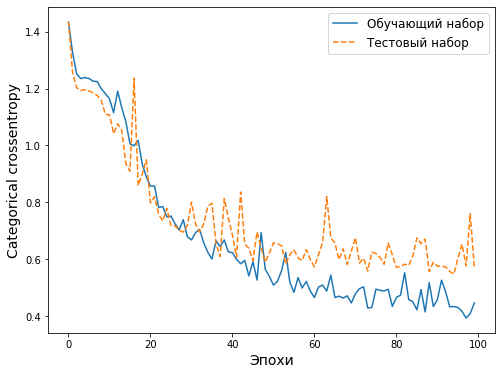

In [384]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'], label = "Обучающий набор") 
plt.plot(history.history['val_loss'],linestyle = '--',label = "Тестовый набор")
fig.set_figwidth(8)    
fig.set_figheight(6)
ax.legend(prop={"size":12})
ax.set_ylabel("Categorical crossentropy",fontsize=14)
ax.set_xlabel('Эпохи',fontsize=14)

In [ ]:
#График loss достаточно шумный, но при малой скорости обучения модель застривала в локальных минимумах и не могла дойти до аналогичных значений.

Как можно видеть, значения ошибки уменьшаются в течении обучении как на обучающей, так и на валидационной выборке - модель сходится.

Метрики

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'f1')

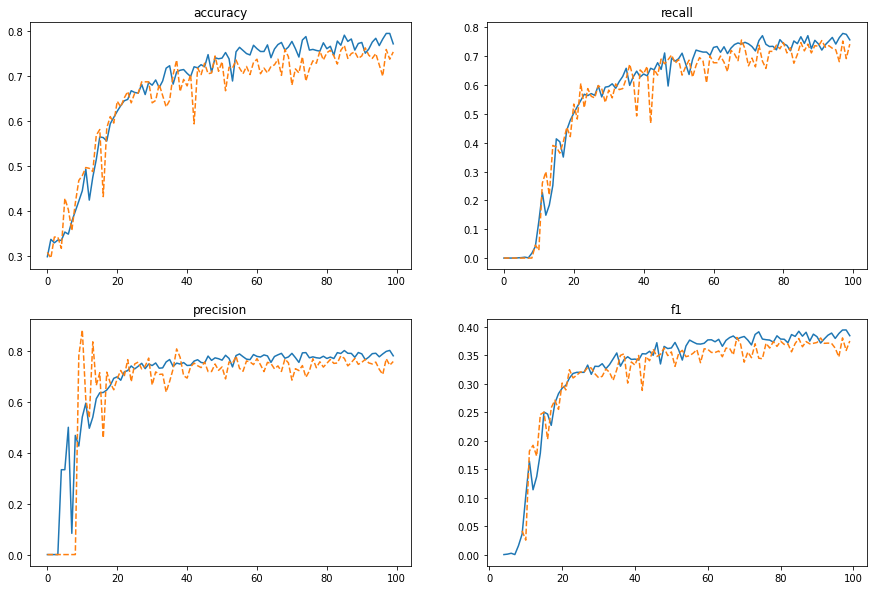

In [385]:
plt.figure(figsize=[15,10])

plt.subplot(2,2,1)
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'],linestyle = '--')
plt.title("accuracy")

plt.subplot(2,2,2)
plt.plot(history.history['recall']) 
plt.plot(history.history['val_recall'],linestyle = '--')
plt.title("recall")

plt.subplot(2,2,3)
plt.plot(history.history['precision']) 
plt.plot(history.history['val_precision'],linestyle = '--')
plt.title("precision")

plt.subplot(2,2,4)
plt.plot(np.array(history.history['recall'])*np.array(history.history['precision'])/(np.array(history.history['precision'])+np.array(history.history['recall']))) 
plt.plot(np.array(history.history['val_recall'])*np.array(history.history['val_precision'])/(np.array(history.history['val_precision'])+np.array(history.history['val_recall'])),linestyle = '--')
plt.title("f1")


На данных графиках видно, что значения метрик качества классификации растут на валидационном наборе в течении обучения и идут близко к значениям для обучающей выборки. Переобучения не наступает, модель обучается верно.

Подробно рассмотрим матрицу ошибок, чтобы оценить, сбаланисрованность точность предсказаний по различным классам и обнаружить основные источники ошибок.

In [ ]:
xticklabels, yticklabels = ["H1N1","H1N2","H1N2v","H1"],["H1N1","H1N2","H1N2v","H1"]

In [590]:
pred = model(inputs[:int(len(inputs)*0.25)])
cf_matrix = sklearn.metrics.confusion_matrix(targets[:int(len(inputs)*0.25)].argmax(axis=1),np.array(pred).argmax(axis=1))
#cf_matrix = np.array(matrix).sum(axis = 0)

In [591]:
M = []
for i in range(4):
  m = []
  for j in range(4):
      m.append(cf_matrix[i][j]/np.sum(cf_matrix[i]))
  M.append(m)
M = np.array(M)

In [ ]:
#Для тестовой выборки

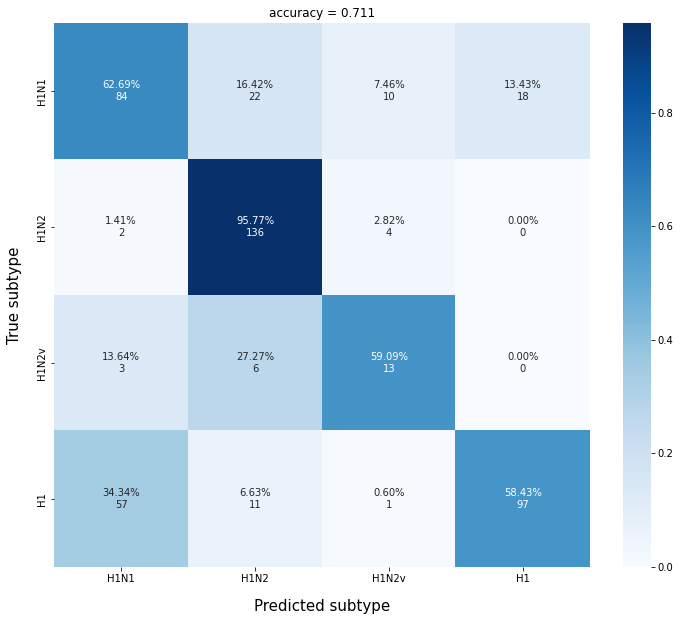

In [592]:
group_counts = ["{0:.2%}".format(value) for value in
                M.flatten()]
group_percentages = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

fig, ax = plt.subplots()

sns.heatmap(M, annot=labels,xticklabels = xticklabels, yticklabels= yticklabels, fmt='', cmap='Blues')
plt.title("accuracy = "+str(round(np.diagonal(cf_matrix).sum()/cf_matrix.sum(),3)))

fig.set_figwidth(12)    
fig.set_figheight(10)
ax.set_ylabel("True subtype",  fontsize=15,labelpad=15)
ax.set_xlabel("Predicted subtype",  fontsize=15,labelpad=15)
plt.show()

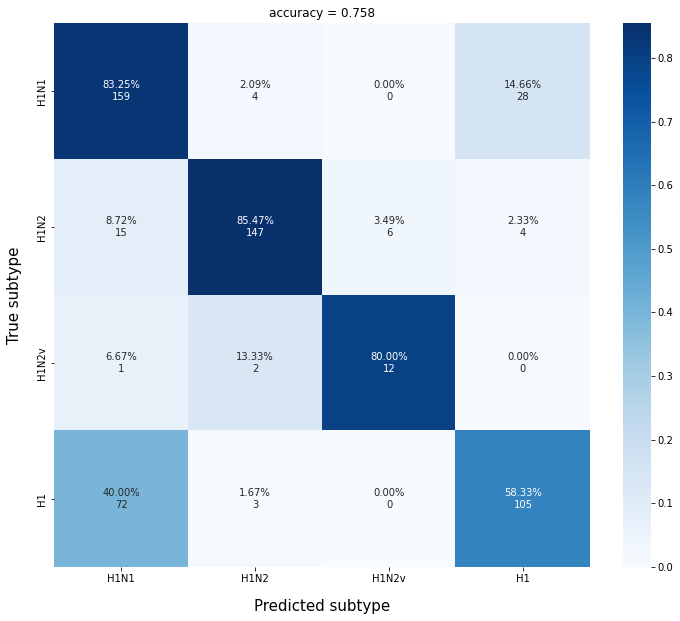

In [ ]:
group_counts = ["{0:.2%}".format(value) for value in
                M.flatten()]
group_percentages = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

fig, ax = plt.subplots()

sns.heatmap(M, annot=labels,xticklabels = xticklabels, yticklabels= yticklabels, fmt='', cmap='Blues')
plt.title("accuracy = "+str(round(np.diagonal(cf_matrix).sum()/cf_matrix.sum(),3)))

fig.set_figwidth(12)    
fig.set_figheight(10)
ax.set_ylabel("True subtype",  fontsize=15,labelpad=15)
ax.set_xlabel("Predicted subtype",  fontsize=15,labelpad=15)
plt.show()

Анализируя данную матрицу ошибок, сразу видно основной сценарий ошибок модели - предсказание подтипа H1N1 для подтипа H1, также в значимом числе случаев возникает обратный сценарий. По остальным значеням матрицы особенностей не наблюдается и классы хорошо разделяются. Путанциа классов H1 и H1N1 возникала для разных параметров обучения и разных выборок данных из H1N1, это может говорить о сложности разделения данных классов. Поскольку ошибка возникает между сбаланисрованным между собой классами, то проблема заключается не в дисбалансе (если бы напрмиер не определялся бы класс H1N2v находящейся в меньшенстве по представителям). Для улучшения качества логичным будет использовать большей обьем данных по H1N1, поскольку у нас их в избытке. Для сохранения баланса при обучения далее будет опробован ансамбыльный подход, с обучением нескольких моделей аналогичным образом, но с использованием различных поднаборов по H1N1.

In [ ]:
#дополнительно по данной модели

Также взгялнем на аналогичную матрицу для обучающих данных

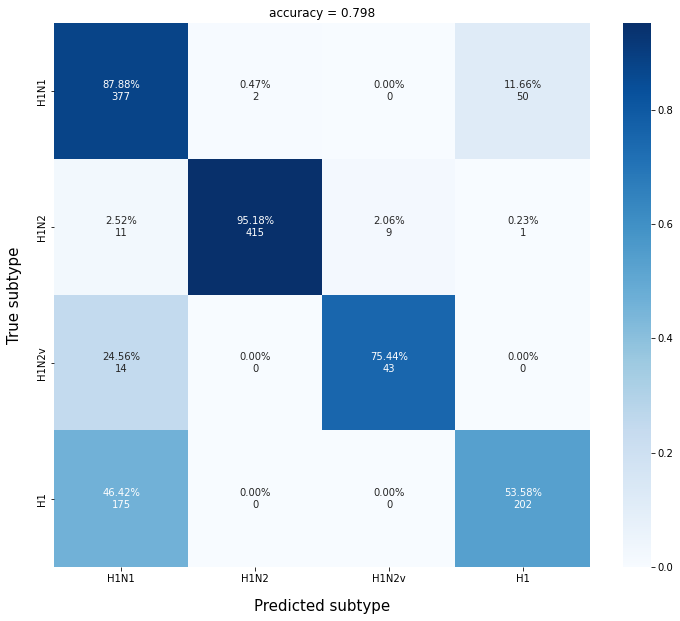

In [392]:
group_counts = ["{0:.2%}".format(value) for value in
                M.flatten()]
group_percentages = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

fig, ax = plt.subplots()

sns.heatmap(M, annot=labels,xticklabels = xticklabels, yticklabels= yticklabels, fmt='', cmap='Blues')
plt.title("accuracy = "+str(round(np.diagonal(cf_matrix).sum()/cf_matrix.sum(),3)))

fig.set_figwidth(12)    
fig.set_figheight(10)
ax.set_ylabel("True subtype",  fontsize=15,labelpad=15)
ax.set_xlabel("Predicted subtype",  fontsize=15,labelpad=15)
plt.show()

In [393]:
#как можно видеть распредления ошибок на тестовой и обучающей выборки схожи, что говорит об обобщающей способности модели.

В связи с тем что обьем данных достаточно мал, и обучение не занимает много времени, для более подробной оценки качества модели, можно провести кросс-валидацию более популярную для классического машинного обучения(в связи с большими затратами времени и мощностей на обучение нейросетей)

In [546]:
inputs, targets = sklearn.utils.shuffle(Xt,Y,random_state=41)

In [532]:
targets.shape

(1857, 4)

In [619]:
#inputs, targets = sklearn.utils.shuffle(Xt,Y,random_state=41)
histories = []
confs = []

fold_no = 1
num_folds = 5
l = len(inputs)
lf =int(l//num_folds)

#kfold = KFold(n_splits=num_folds, shuffle=True)
#for train, test in kfold.split(inputs, targets):
for i in range(num_folds):
  model = Sequential()
  model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(75, 20)))
  model.add(LSTM(256, activation='tanh'))
  model.add(Dense(512,activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256,activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(4,activation = 'softmax'))
  INIT_LR = 0.00004
  def lr_scheduler(epoch):
    return INIT_LR * 0.95* epoch
  model.compile(
    optimizer=tf.keras.optimizers.Adamax(lr=INIT_LR),  #выбор оптимизатора
    loss='categorical_crossentropy', #в качестве функции ошибки будем использовать классическую для классификации кросс-энтропию 
    metrics=["accuracy",tf.keras.metrics.Recall(name = 'recall'),tf.keras.metrics.Precision(name = 'precision')] #Выбор метрик для контроля переобучения и оценки качества модели
    )
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = model.fit(np.concatenate([inputs[:i*lf],inputs[lf*(i+1):]]), np.concatenate([targets[:i*lf],targets[lf*(i+1):]]),
            batch_size=32,
            epochs=100,
            validation_data = (inputs[i*lf:lf*(i+1)], targets[i*lf:lf*(i+1)]),
            verbose=0,
            callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)]
            )

  histories.append(history)

  pred = model(inputs[i*lf:lf*(i+1)])
  cf_matrix = sklearn.metrics.confusion_matrix(targets[i*lf:lf*(i+1)].argmax(axis=1),np.array(pred).argmax(axis=1))
  confs.append(cf_matrix)

  fold_no = fold_no + 1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...


In [620]:
#Посмотрим на матрицу средних значения по фолдам, а также матрицу дисперсий(чтобы оценить разброс показателей по каждому классу), а также на матрицы ошибок для каждого фолда.
Ms = []
for f in confs:
  M = []
  for i in range(4):
    m = []
    for j in range(4):
        m.append(f[i][j]/np.sum(f[i]))
    M.append(m)
  M = np.array(M)
  Ms.append(M)

In [621]:
M  = np.array(Ms).mean(axis = 0)
V  = np.array(Ms).var(axis = 0)
cf_matrix = np.array(confs).sum(axis = 0)

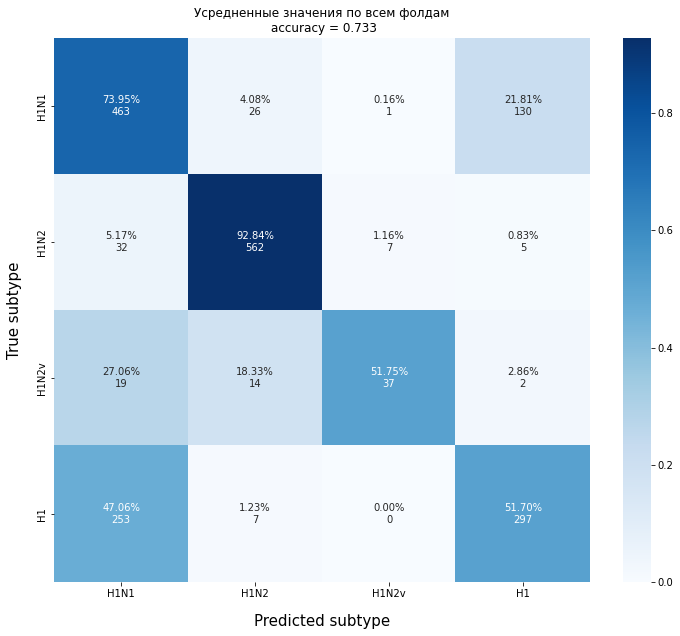

In [609]:
group_counts = ["{0:.2%}".format(value) for value in
                M.flatten()]
group_percentages = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

fig, ax = plt.subplots()


sns.heatmap(M, annot=labels,xticklabels = xticklabels, yticklabels= yticklabels, fmt='', cmap='Blues')
plt.title("Усредненные значения по всем фолдам\n accuracy = "+str(round(np.diagonal(cf_matrix).sum()/cf_matrix.sum(),3)))

fig.set_figwidth(12)    
fig.set_figheight(10)
ax.set_ylabel("True subtype",  fontsize=15,labelpad=15)
ax.set_xlabel("Predicted subtype",  fontsize=15,labelpad=15)
plt.show()

Результаты на кросс валидации соотносятся с предедущеми, так же была выявлено не лучшее положение дел с классом H1N2v, который модель может определять как H1N1 и H1N2, главной сложностью с ним является его малочисленность.

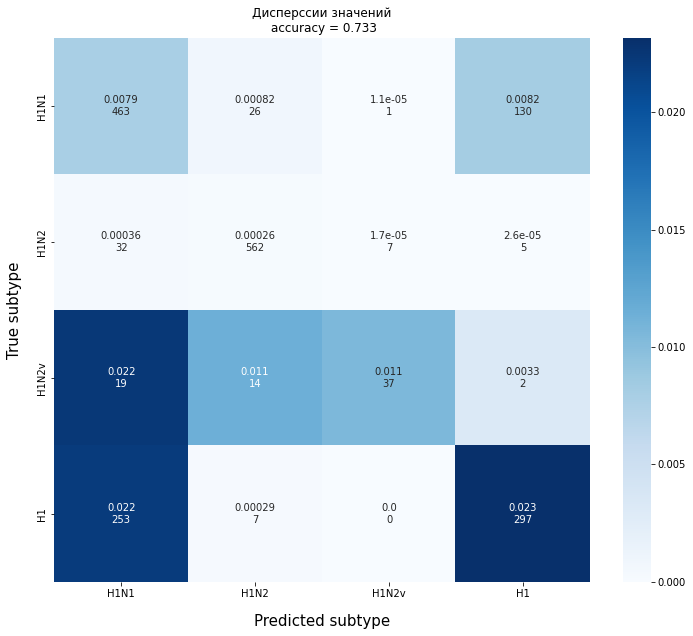

In [612]:
group_counts = ["{0:.2}".format(value) for value in
                V.flatten()]
group_percentages = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

fig, ax = plt.subplots()


sns.heatmap(V, annot=labels,xticklabels = xticklabels, yticklabels= yticklabels, fmt='', cmap='Blues')
plt.title("Дисперссии значений\n accuracy = "+str(round(np.diagonal(cf_matrix).sum()/cf_matrix.sum(),3)))

fig.set_figwidth(12)    
fig.set_figheight(10)
ax.set_ylabel("True subtype",  fontsize=15,labelpad=15)
ax.set_xlabel("Predicted subtype",  fontsize=15,labelpad=15)
plt.show()

Смотря на матрицу дисперсий можно заметить, что наибольшая разница результатов модели связана с парой классов H1 и H1N1 и с классом H1N2v, убедимся в этом посомтрев более подробно на набор самих матрицы.

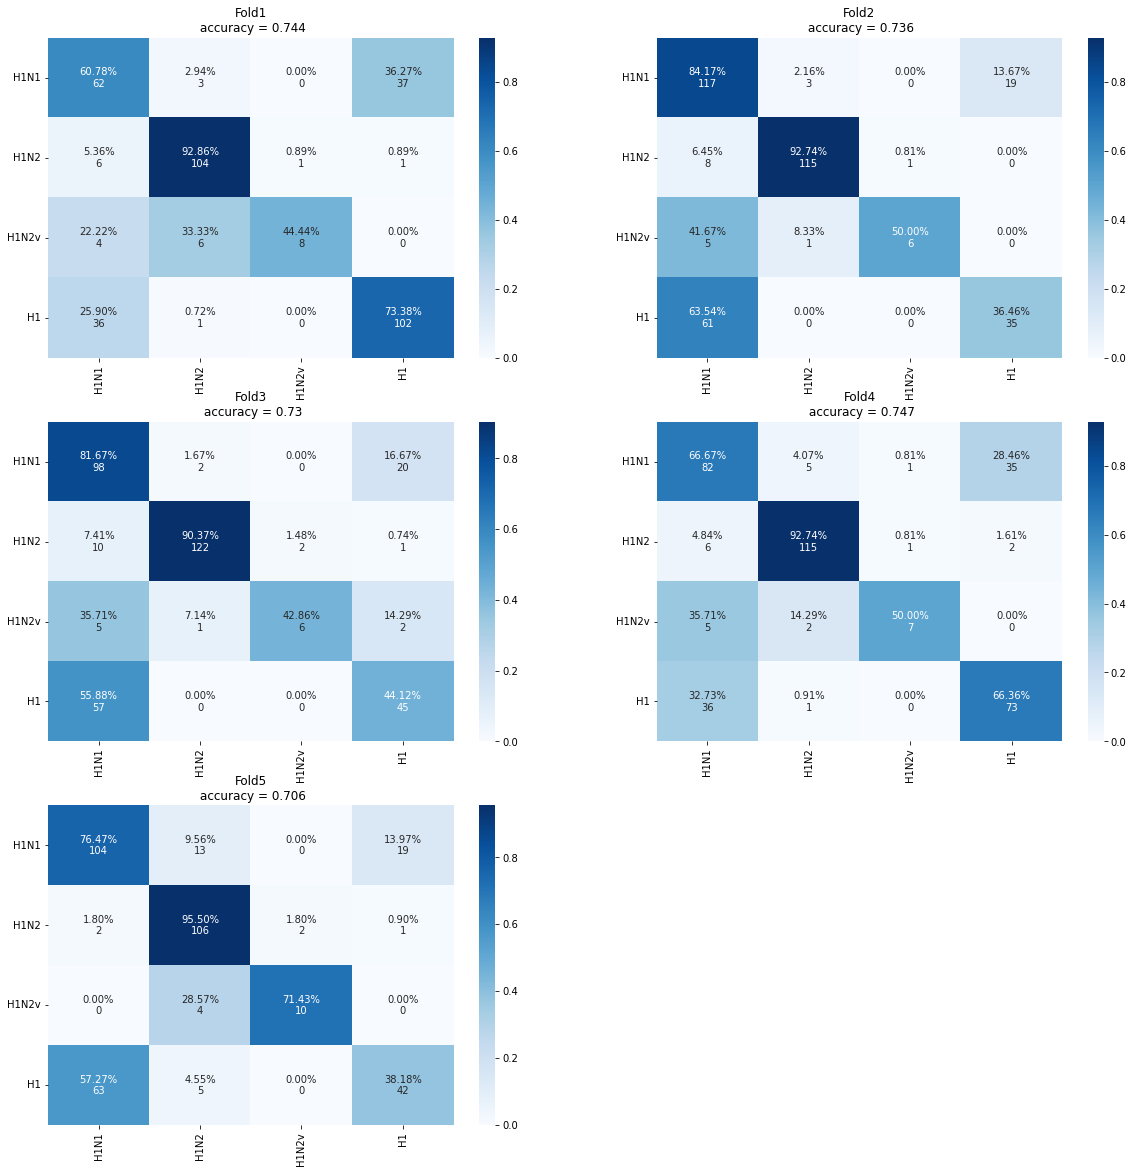

In [613]:
#Посмотрим таже на отдельные матрицы
fig, ax = plt.subplots()

for i in range(5):
  M  = np.array(Ms[i])
  cf_matrix = np.array(confs[i])
  
  group_counts = ["{0:.2%}".format(value) for value in
                M.flatten()]
  group_percentages = ["{0:0.0f}".format(value) for value in
                     cf_matrix.flatten()]
  labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(4,4)

  plt.subplot(3,2,i+1)
  sns.heatmap(M, annot=labels,xticklabels = xticklabels, yticklabels= yticklabels, fmt='', cmap='Blues')
  plt.title("Fold"+str(i+1)+"\n accuracy = "+str(round(np.diagonal(cf_matrix).sum()/cf_matrix.sum(),3)))
  
fig.set_figwidth(20)    
fig.set_figheight(20)

Как можно видеть для разных фолдов получается различное соотношение ошибок по паре H1 и H1N1, иногда модель выдает один из этих классов за другой, иногда наоборот, бывают же уровновешенные ситуации как для фолда 4, идея с ансамблированием использованная далее как раз так приводит к сбалансированной ситуации.

Посмотрим теперь на ансамбль из 20 моделей обученных на разных подвыборках H1N1 и одних данных по 3 остальным классам.

In [370]:
models = []
histories = []
#h1n2_oh = h1n2_oh[:300]
#h1n2v_oh = h1n2v_oh[:300]
#h1_oh = h1_oh[:500]

#h1n2_label = h1n2_label[:300]
#h1n2v_label = h1n2v_label[:300]
#h1_label = h1_label[:300]
X1 = np.concatenate([h1n2_oh,h1n2v_oh,h1_oh])
Y1 = np.concatenate([h1n2_label,h1n2v_label,h1_label])

h1n1test = np.random.choice(df[df["Subtype"] == "H1N1"]["seq"],180)
h1n1_oht = one_hot(h1n1test) 
h1n1t_label = np.zeros([len(h1n1test),4])
h1n1t_label[:,0] = np.ones(len(h1n1test))

X1 = np.concatenate([h1n2_oh,h1n2v_oh,h1_oh])
Y1 = np.concatenate([h1n2_label,h1n2v_label,h1_label])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.3, random_state=42)

X_test2 = transform(np.concatenate([X_test1,h1n1_oht]),20)
y_test2 = np.concatenate([y_test1,h1n1t_label])
for i in range(20):
    h1n11 = np.random.choice(df[df["Subtype"] == "H1N1"]["seq"],400)
    h1n1_oh1 = one_hot(h1n11) 
    h1n1_label1 = np.zeros([len(h1n11),4])
    h1n1_label1[:,0] = np.ones(len(h1n11))

    X_train2 = transform(np.concatenate([X_train1,h1n1_oh1]),20)
    y_train2 = np.concatenate([y_train1,h1n1_label1])

    X_tr, y_tr = sklearn.utils.shuffle(X_train2,y_train2)

    model = Sequential()
    model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(75, 20)))
    model.add(LSTM(256, activation='tanh'))
    model.add(Dense(512,activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4,activation = 'softmax'))

    INIT_LR = 0.00004

    def lr_scheduler(epoch):
        return INIT_LR * 0.97* epoch
        
    model.compile(
        optimizer=tf.keras.optimizers.Adamax(lr=INIT_LR),  #выбор оптимизатора
        loss='categorical_crossentropy', #в качестве функции ошибки будем использовать классическую для классификации кросс-энтропию 
        metrics=["accuracy",tf.keras.metrics.Recall(name = 'recall'),tf.keras.metrics.Precision(name = 'precision')] #Выбор метрик для контроля переобучения и оценки качества модели
        )
    
    histories.append(model.fit(
    X_tr, y_tr,
    epochs=100,
    validation_data=(X_test2,y_test2),
    verbose=0,
    batch_size=32,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)]
    ))

    models.append(model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [371]:
def cooperate_pred(models,x):
  n = len(models)
  print(n)
  res = models[0].predict(x)
  for i in range(n-1):
    res+=models[i+1].predict(x)
  #return np.argmax(res,axis = 1)
  return res

In [372]:
pred2 = cooperate_pred(models,X_test2)
cf_matrix2 = sklearn.metrics.confusion_matrix(y_test2.argmax(axis=1),np.array(pred2).argmax(axis=1))
M2 = []
for i in range(4):
  m2 = []
  for j in range(4):
      m2.append(cf_matrix2[i][j]/np.sum(cf_matrix2[i]))
  M2.append(m2)
M2 = np.array(M2)

20


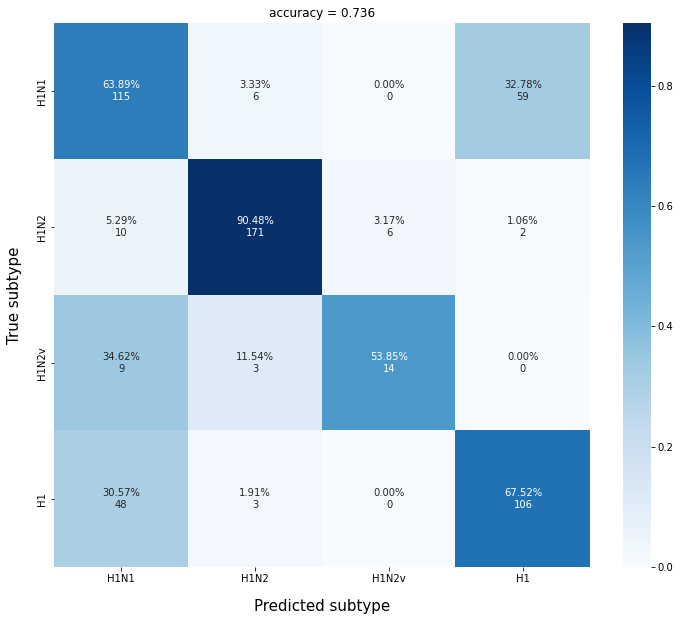

In [374]:
group_counts = ["{0:.2%}".format(value) for value in
                M2.flatten()]
group_percentages = ["{0:0.0f}".format(value) for value in
                     cf_matrix2.flatten()]
labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)

fig, ax = plt.subplots()

sns.heatmap(M2, annot=labels,xticklabels = xticklabels, yticklabels= yticklabels, fmt='', cmap='Blues')
plt.title("accuracy = "+str(round(np.diagonal(cf_matrix2).sum()/cf_matrix2.sum(),3)))

fig.set_figwidth(12)    
fig.set_figheight(10)
ax.set_ylabel("True subtype",  fontsize=15,labelpad=15)
ax.set_xlabel("Predicted subtype",  fontsize=15,labelpad=15)
plt.show()

Данное решение сбалансировало ошибки между H1 и H1N1, но к сожалению общее качество модели мало изменилось.